In [1]:
#Imports
import xarray as xr
import numpy as np
import pandas as pd
from collections import OrderedDict
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
from tqdm import tqdm
import geopandas as gp
import pooch
import regionmask

In [2]:
#Verbose?
verbose='true'

#Choose ERA5 or NCEP2. This switch also selects the eval/???? subfolders, so do not mix and match as this 
#would lead to incorrect results.
reanalysis='ERA5'

#Define paths
obs_path='obs/'
model_path='/p/project/chhb19/streffing1/software/cmpi-tool/input/'
out_path='output/'
eval_path='eval/'+reanalysis+'/'
time = '198912-201411'


#Define the name and evaluated variables for your model run


cmip6 = {
    'ACCESS-CM2':   [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'AWI-CM1-MR':   [           'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'BCC-SM2-MR':   [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'CAMS':         [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'CanESM5':      [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'CAS-ESM2-0':   [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos',                         ],
    'CESM2':        [ 'siconc', 'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos', 'mlotst'                ],
    'CIESM':        [           'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos',           'thetao', 'so'],
    'CMCC-CM2-SR5': [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'CNRM-CM6-1-HR':[ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst'                ],
    'E3SM-1-1':     [ 'siconc', 'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'EC-Earth3':    [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'FGOALS-f3-L':  [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'FIO-ESM-2-0':  [ 'siconc', 'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos',           'thetao', 'so'],
    'GISS-E2-1-G':  [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'HadGEM3MM':    [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'ICON-ESM-LR':  [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'IITM-ESM':     [           'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg',        'tos',                         ],
    'INM5':         [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg',                         'thetao', 'so'],
    'IPSL-CM6A-LR': [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'KIOST-ESM':    [ 'siconc', 'tas', 'clt',       'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst',               ],
    'MCMUA1':       [           'tas',        'pr', 'rlut', 'uas', 'vas', 'ua', 'zg',        'tos',           'thetao', 'so'],
    'MIROC6':       [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos',                         ],
    'MPI-ESM1-2-HR':[ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'MRI-ESM2-0':   [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas',             'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'NESM3':        [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],   
    'NOAA-GFDL':    [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos',           'thetao', 'so'],
    'NorESM2-MM':   [ 'siconc', 'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'SNU':          [ 'siconc', 'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos',           'thetao', 'so'],
    'TaiESM1':      [ 'siconc', 'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos',           'thetao', 'so'],
}

awi_cm3_v31= {
    'AWI-CM3-v3.1':[ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
}
access_cm2= {
    'ACCESS-CM2':   [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
}

models = access_cm2

eval_models = cmip6

#Select for each variable which vertical levels shall be taken into account
var_depths ={    
        'siconc':['surface'],
        'tas':['surface'],
        'clt':['surface'],
        'pr':['surface'],
        'rlut':['surface'],
        'uas':['surface'],
        'vas':['surface'],
        'ua':['300hPa'],
        'zg':['500hPa'],
        'zos':['surface'],
        'tos':['surface'],
        'mlotst':['surface'],
        'thetao':['10m','100m','1000m'],
        'so':['10m','100m','1000m'],
}


#Define which observational dataset biases are computed against for each variable
obs = { 
    'siconc':'OSISAF',
    'tas':reanalysis,
    'clt':'MODIS',
    'pr':'GPCP',
    'rlut':'CERES',
    'uas':reanalysis,
    'vas':reanalysis,
    'ua':reanalysis,
    'zg':reanalysis,
    'zos':'NESDIS',
    'tos':'HadISST2',
    'mlotst':'C-GLORSv7',
    'thetao':'EN4',
    'so':'EN4',
}




In [356]:
file = pooch.retrieve(
    "https://pubs.usgs.gov/of/2006/1187/basemaps/continents/continents.zip", None
)
continents = gp.read_file("zip://" + file)
ocean_basins = gp.read_file("geojson/ocean_basins.geojson")

display(continents)

lon = np.arange(0, 360, 2)
lat = np.arange(-90, 90, 2)

continents_mask = regionmask.mask_3D_geopandas(continents, lon, lat)
ocean_basins_mask = regionmask.mask_3D_geopandas(ocean_basins, lon, lat)

CONTINENT                                           geometry
0           Asia  MULTIPOLYGON (((93.27554 80.26361, 93.31304 80...
1  North America  MULTIPOLYGON (((-25.28167 71.39166, -25.32889 ...
2         Europe  MULTIPOLYGON (((58.06138 81.68776, 57.98055 81...
3         Africa  MULTIPOLYGON (((0.69465 5.77337, 0.66667 5.803...
4  South America  MULTIPOLYGON (((-81.71306 12.49028, -81.72014 ...
5        Oceania  MULTIPOLYGON (((-177.39334 28.18416, -177.3958...
6      Australia  MULTIPOLYGON (((142.27997 -10.26556, 142.21053...
7     Antarctica  MULTIPOLYGON (((51.80305 -46.45667, 51.72139 -...

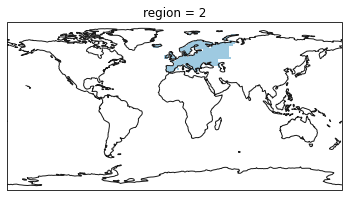

In [354]:
from matplotlib import colors as mplc

cmap1 = mplc.ListedColormap(["none", "#9ecae1"])

f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))

mask_3D.sel(region=2).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    cmap=cmap1,
)

ax.coastlines(color="0.1");

In [231]:
#Select seasons
seasons = ['MAM', 'JJA', 'SON', 'DJF']

#Define regions
regions={
    #'glob' : {
    #'lat_min':-90,
    #'lat_max':90,
    #'lon_min':0,
    #'lon_max':360,
    #'plot_color':'none',},
         
    'arctic' : {
    'lat_min':60,
    'lat_max':90,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'red',},
         
    'northmid' : {
    'lat_min':30,
    'lat_max':60,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'lightgrey',},
         
    'tropics' : {
    'lat_min':-30,
    'lat_max':30,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'green',},
         
    #'innertropics' : {
    #'lat_min':-15,
    #'lat_max':15,
    #'lon_min':0,
    #'lon_max':360,
    #'plot_color':'green',},
        
    'nino34' : {
    'lat_min':-5,
    'lat_max':5,
    'lon_min':190,
    'lon_max':240,
    'plot_color':'yellow',},
         
    'southmid' : {
    'lat_min':-60,
    'lat_max':-30,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'pink',},
         
    'antarctic' : {
    'lat_min':-90,
    'lat_max':-60,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'blue',},
          
}

# This stores all regions for which the evaluation data has been generated
all_regions=[ 'glob', 'arctic', 'northmid', 'tropics', 'innertropics', 'nino34', 'southmid', 'antarctic']


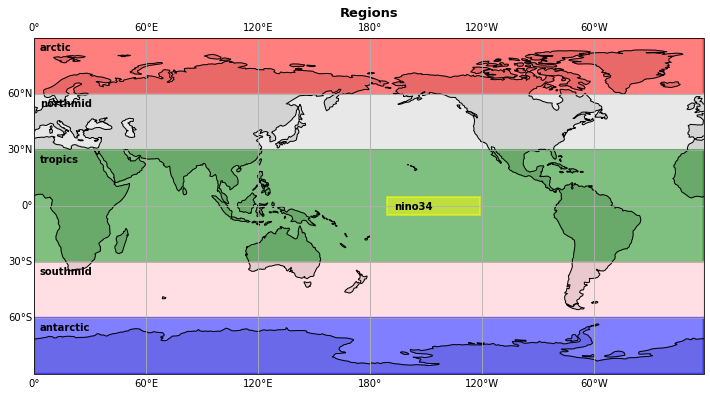

In [234]:
# Visulatize regions

if verbose == 'true':
    projection = ccrs.PlateCarree()

    # Plot the leading EOF expressed as correlation in the Pacific domain.
    plt.figure(figsize=(12,9))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

    ax.add_feature(cfeature.LAND, color='lightgrey')
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    plt.title('Regions', fontsize=13,fontweight="bold")

    ax.set_extent([0, -1, 90, -90])
    for region in regions:
        if region == 'glob':
            continue 
        else:
            lon_min=regions[region]['lon_min']
            lon_max=regions[region]['lon_max']
            lat_min=regions[region]['lat_min']
            lat_max=regions[region]['lat_max']
            ax.add_patch(mpatches.Rectangle(xy=[lon_min-1, lat_min], width=lon_max-lon_min, height=lat_max-lat_min,
                                            facecolor=regions[region]['plot_color'],
                                            alpha=0.5,
                                            edgecolor=regions[region]['plot_color'],
                                            lw='2',
                                            transform=ccrs.PlateCarree())
                         )
            plt.text(lon_min-177,lat_max-7,region,weight='bold')

    ax.tick_params(labelsize=13)


In [311]:
print('Loading obs data')

ds_obs = OrderedDict()

for var,depths in zip(obs,var_depths):
    for depth in np.arange(0,len(var_depths[depths])):
        for seas in seasons:
            if verbose == 'true':
                print('loading '+obs_path+var+'_'+obs[var]+'_'+var_depths[depths][depth]+'_'+seas+'.nc')

            intermediate = xr.open_dataset(obs_path+var+'_'+obs[var]+'_'+var_depths[depths][depth]+'_'+seas+'.nc')
            ds_obs[var,var_depths[depths][depth],seas] = intermediate.compute()
            try:
                ds_obs[var,var_depths[var][depth],seas]=ds_obs[var,var_depths[var][depth],seas].drop('time_bnds')
            except:
                pass
            try:
                ds_obs[var,var_depths[var][depth],seas]=ds_obs[var,var_depths[var][depth],seas].drop('time_bnds_2')
            except:
                pass
            try:
                ds_obs[var,var_depths[var][depth],seas]=ds_obs[var,var_depths[var][depth],seas].drop('depth')
            except:
                pass
            

Loading obs data
loading obs/siconc_OSISAF_surface_MAM.nc
loading obs/siconc_OSISAF_surface_JJA.nc
loading obs/siconc_OSISAF_surface_SON.nc
loading obs/siconc_OSISAF_surface_DJF.nc
loading obs/tas_ERA5_surface_MAM.nc
loading obs/tas_ERA5_surface_JJA.nc
loading obs/tas_ERA5_surface_SON.nc
loading obs/tas_ERA5_surface_DJF.nc
loading obs/clt_MODIS_surface_MAM.nc
loading obs/clt_MODIS_surface_JJA.nc
loading obs/clt_MODIS_surface_SON.nc
loading obs/clt_MODIS_surface_DJF.nc
loading obs/pr_GPCP_surface_MAM.nc
loading obs/pr_GPCP_surface_JJA.nc
loading obs/pr_GPCP_surface_SON.nc
loading obs/pr_GPCP_surface_DJF.nc
loading obs/rlut_CERES_surface_MAM.nc
loading obs/rlut_CERES_surface_JJA.nc
loading obs/rlut_CERES_surface_SON.nc
loading obs/rlut_CERES_surface_DJF.nc
loading obs/uas_ERA5_surface_MAM.nc
loading obs/uas_ERA5_surface_JJA.nc
loading obs/uas_ERA5_surface_SON.nc
loading obs/uas_ERA5_surface_DJF.nc
loading obs/vas_ERA5_surface_MAM.nc
loading obs/vas_ERA5_surface_JJA.nc
loading obs/vas_ERA

In [312]:
ds_obs

OrderedDict([(('siconc', 'surface', 'MAM'),
              <xarray.Dataset>
              Dimensions:  (time: 1, lon: 180, lat: 91)
              Coordinates:
                * time     (time) datetime64[ns] 2014-05-16T12:00:00
                * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
                * lat      (lat) float64 -90.0 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 90.0
              Data variables:
                  siconc   (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
              Attributes: (12/43)
                  CDI:                       Climate Data Interface version 1.9.9 (https://...
                  source:                    FCDR of SMMR / SSMI / SSMIS Brightness Tempera...
                  institution:               OSISAF - EUMETSAT
                  Conventions:               CF-1.6 ACDD-1.3
                  title:                     Sea Ice Concentration Climate Data Record from...
                  

In [20]:
print('Loading model data')

ds_model = OrderedDict()

for model in tqdm(models):
    for var in models[model]:
        for depth in np.arange(0,len(var_depths[var])):
            for seas in seasons:
                if verbose == 'true':
                    print('loading '+model_path+var+'_'+model+'_'+time+'_'+var_depths[var][depth]+'_'+seas+'.nc')
                intermediate = xr.open_mfdataset(model_path+var+'_'+model+'_'+time+'_'+var_depths[var][depth]+'_'+seas+'.nc')
                intermediate = intermediate.squeeze(drop=True)
                ds_model[var,var_depths[var][depth],seas,model] = intermediate.compute()
                try:
                    ds_model[var,var_depths[var][depth],seas,model]=ds_model[var,var_depths[var][depth],seas,model].drop('time_bnds')
                except:
                    pass
                try:
                    ds_model[var,var_depths[var][depth],seas,model]=ds_model[var,var_depths[var][depth],seas,model].drop('depth')
                except:
                    pass


Loading model data


  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_ACCESS-CM2_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_ACCESS-CM2_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_ACCESS-CM2_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_ACCESS-CM2_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_ACCESS-CM2_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_ACCESS-CM2_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_ACCESS-CM2_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_ACCESS-CM2_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_ACCESS-CM2_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffin

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.08s/it]


In [21]:
print('Calculating absolute error and field mean of abs error')

# Returns equvalent to cdo fldmean ()
def fldmean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    ds_weighted = ds.weighted(weights)
    return ds.mean(("lon", "lat"))


abs_error = OrderedDict()
mean_error = OrderedDict()

for model in tqdm(models):
    for var in models[model]:
        for depth in np.arange(0,len(var_depths[var])):
            for region in regions:
                filter1 = ds_model[var,var_depths[var][depth],seas,model].lat>regions[region]['lat_min']
                filter2 = ds_model[var,var_depths[var][depth],seas,model].lat<regions[region]['lat_max']
                filter3 = ds_model[var,var_depths[var][depth],seas,model].lon>regions[region]['lon_min']
                filter4 = ds_model[var,var_depths[var][depth],seas,model].lon<regions[region]['lon_max']

                for seas in seasons:
                    abs_error[var,var_depths[var][depth],seas,model,region]=np.sqrt((ds_model[var,var_depths[var][depth],seas,model].where(filter1 & filter2 & filter3 & filter4)-
                                                       ds_obs[var,var_depths[var][depth],seas]).where(filter1 & filter2 & filter3 & filter4)*
                                                      (ds_model[var,var_depths[var][depth],seas,model].where(filter1 & filter2 & filter3 & filter4)-
                                                       ds_obs[var,var_depths[var][depth],seas].where(filter1 & filter2 & filter3 & filter4)))
                    mean_error[var,var_depths[var][depth],seas,model,region] = fldmean(abs_error[var,var_depths[var][depth],seas,model,region])


Calculating absolute error and field mean of abs error


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/it]


In [115]:
print('Writing field mean of errors into csv files')

for model in tqdm(models):
    with open(out_path+'abs/'+model+'.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Variable','Region','Level','Season','AbsMeanError'])
        for var in models[model]:
            for region in regions:
                for depth in np.arange(0,len(var_depths[var])):
                    for seas in seasons:
                        writer.writerow([var,region,var_depths[var][depth],seas,np.squeeze(mean_error[var,var_depths[var][depth],seas,model,region].to_array(var).values[0])])

Writing field mean of errors into csv files


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.03it/s]


In [116]:
print('Reading precalculated cmip6 field mean of errors from csv files')

max_depth=0
for var in var_depths:
    if len(var_depths[var]) > max_depth:
        max_depth = len(var_depths[var])

collect = np.empty([len(eval_models),len(obs),len(regions),max_depth,len(seasons)])*np.nan
i=0
for eval_model in tqdm(eval_models):
    df = pd.read_csv(eval_path+eval_model+'.csv', delimiter=' ')
    values = df['AbsMeanError']
    regions_csv = df['Region']
    var_csv = df['Variable']
    j=0
    r=0
    for var in obs:
        k=0
        a=(df['Variable']==var).to_list()
        if verbose == 'true':
            if any(a): # Check if variable appears in list. If not, skip it.
                print('reading: ',eval_model,var)
            else:
                print('filling: ',eval_model,var)
        for region in regions:
            l=0
            for depth in np.arange(0,len(var_depths[var])):
                m=0
                for seas in seasons:
                    if any(a): # Check if variable appears in csv. If not, skip it.
                        if regions_csv[r] not in regions: # Check if region from csv part of the analysis. Else advance
                            while True:
                                r+=1
                                if regions_csv[r] in regions:
                                    break
                        collect[i,j,k,l,m]=values[r]
                        r+=1
                    m+=1
                l+=1
            k+=1
        j+=1
    i+=1
# Ignoring non useful warning:
# /tmp/ipykernel_19478/363568120.py:37: RuntimeWarning: Mean of empty slice
#  ensmean=np.nanmean(collect,axis=0)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    ensmean=np.nanmean(collect,axis=0)


Reading precalculated cmip6 field mean of errors from csv files


 20%|███████████████████████████████████                                                                                                                                            | 6/30 [00:00<00:01, 19.83it/s]

reading:  ACCESS-CM2 siconc
reading:  ACCESS-CM2 tas
reading:  ACCESS-CM2 clt
reading:  ACCESS-CM2 pr
reading:  ACCESS-CM2 rlut
reading:  ACCESS-CM2 uas
reading:  ACCESS-CM2 vas
reading:  ACCESS-CM2 ua
reading:  ACCESS-CM2 zg
reading:  ACCESS-CM2 zos
reading:  ACCESS-CM2 tos
reading:  ACCESS-CM2 mlotst
reading:  ACCESS-CM2 thetao
reading:  ACCESS-CM2 so
filling:  AWI-CM1-MR siconc
reading:  AWI-CM1-MR tas
reading:  AWI-CM1-MR clt
reading:  AWI-CM1-MR pr
reading:  AWI-CM1-MR rlut
reading:  AWI-CM1-MR uas
reading:  AWI-CM1-MR vas
reading:  AWI-CM1-MR ua
reading:  AWI-CM1-MR zg
reading:  AWI-CM1-MR zos
reading:  AWI-CM1-MR tos
reading:  AWI-CM1-MR mlotst
reading:  AWI-CM1-MR thetao
reading:  AWI-CM1-MR so
reading:  BCC-SM2-MR siconc
reading:  BCC-SM2-MR tas
reading:  BCC-SM2-MR clt
reading:  BCC-SM2-MR pr
reading:  BCC-SM2-MR rlut
reading:  BCC-SM2-MR uas
reading:  BCC-SM2-MR vas
reading:  BCC-SM2-MR ua
reading:  BCC-SM2-MR zg
reading:  BCC-SM2-MR zos
reading:  BCC-SM2-MR tos
reading:  BC

 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 16/30 [00:00<00:00, 30.82it/s]

 tos
reading:  CNRM-CM6-1-HR mlotst
filling:  CNRM-CM6-1-HR thetao
filling:  CNRM-CM6-1-HR so
reading:  E3SM-1-1 siconc
reading:  E3SM-1-1 tas
reading:  E3SM-1-1 clt
reading:  E3SM-1-1 pr
reading:  E3SM-1-1 rlut
filling:  E3SM-1-1 uas
filling:  E3SM-1-1 vas
reading:  E3SM-1-1 ua
reading:  E3SM-1-1 zg
reading:  E3SM-1-1 zos
reading:  E3SM-1-1 tos
reading:  E3SM-1-1 mlotst
reading:  E3SM-1-1 thetao
reading:  E3SM-1-1 so
reading:  EC-Earth3 siconc
reading:  EC-Earth3 tas
reading:  EC-Earth3 clt
reading:  EC-Earth3 pr
reading:  EC-Earth3 rlut
reading:  EC-Earth3 uas
reading:  EC-Earth3 vas
reading:  EC-Earth3 ua
reading:  EC-Earth3 zg
reading:  EC-Earth3 zos
reading:  EC-Earth3 tos
reading:  EC-Earth3 mlotst
reading:  EC-Earth3 thetao
reading:  EC-Earth3 so
reading:  FGOALS-f3-L siconc
reading:  FGOALS-f3-L tas
reading:  FGOALS-f3-L clt
reading:  FGOALS-f3-L pr
reading:  FGOALS-f3-L rlut
reading:  FGOALS-f3-L uas
reading:  FGOALS-f3-L vas
reading:  FGOALS-f3-L ua
reading:  FGOALS-f3-L zg
r

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 20/30 [00:00<00:00, 30.69it/s]

filling:  IITM-ESM siconc
reading:  IITM-ESM tas
reading:  IITM-ESM clt
reading:  IITM-ESM pr
reading:  IITM-ESM rlut
reading:  IITM-ESM uas
reading:  IITM-ESM vas
reading:  IITM-ESM ua
reading:  IITM-ESM zg
filling:  IITM-ESM zos
reading:  IITM-ESM tos
filling:  IITM-ESM mlotst
filling:  IITM-ESM thetao
filling:  IITM-ESM so
reading:  INM5 siconc
reading:  INM5 tas
reading:  INM5 clt
reading:  INM5 pr
reading:  INM5 rlut
reading:  INM5 uas
reading:  INM5 vas
reading:  INM5 ua
reading:  INM5 zg
filling:  INM5 zos
filling:  INM5 tos
filling:  INM5 mlotst
reading:  INM5 thetao
reading:  INM5 so
reading:  IPSL-CM6A-LR siconc
reading:  IPSL-CM6A-LR tas
reading:  IPSL-CM6A-LR clt
reading:  IPSL-CM6A-LR pr
reading:  IPSL-CM6A-LR rlut
reading:  IPSL-CM6A-LR uas
reading:  IPSL-CM6A-LR vas
reading:  IPSL-CM6A-LR ua
reading:  IPSL-CM6A-LR zg
reading:  IPSL-CM6A-LR zos
reading:  IPSL-CM6A-LR tos
reading:  IPSL-CM6A-LR mlotst
reading:  IPSL-CM6A-LR thetao
reading:  IPSL-CM6A-LR so
reading:  KIOST-

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.36it/s]

reading:  NESM3 siconc
reading:  NESM3 tas
reading:  NESM3 clt
reading:  NESM3 pr
reading:  NESM3 rlut
reading:  NESM3 uas
reading:  NESM3 vas
reading:  NESM3 ua
reading:  NESM3 zg
reading:  NESM3 zos
reading:  NESM3 tos
reading:  NESM3 mlotst
reading:  NESM3 thetao
reading:  NESM3 so
reading:  NOAA-GFDL siconc
reading:  NOAA-GFDL tas
reading:  NOAA-GFDL clt
reading:  NOAA-GFDL pr
reading:  NOAA-GFDL rlut
reading:  NOAA-GFDL uas
reading:  NOAA-GFDL vas
reading:  NOAA-GFDL ua
reading:  NOAA-GFDL zg
reading:  NOAA-GFDL zos
reading:  NOAA-GFDL tos
filling:  NOAA-GFDL mlotst
reading:  NOAA-GFDL thetao
reading:  NOAA-GFDL so
reading:  NorESM2-MM siconc
reading:  NorESM2-MM tas
reading:  NorESM2-MM clt
reading:  NorESM2-MM pr
reading:  NorESM2-MM rlut
filling:  NorESM2-MM uas
filling:  NorESM2-MM vas
reading:  NorESM2-MM ua
reading:  NorESM2-MM zg
reading:  NorESM2-MM zos
reading:  NorESM2-MM tos
reading:  NorESM2-MM mlotst
reading:  NorESM2-MM thetao
reading:  NorESM2-MM so
reading:  SNU si

In [117]:
print('Placing sums of error into easier to inspect dictionary')

eval_error_mean = OrderedDict()

j=0
for var in tqdm(obs):
    k=0
    for region in regions:
        l=0
        for depth in np.arange(0,len(var_depths[var])):
            m=0
            for seas in seasons:
                eval_error_mean[var,region,var_depths[var][depth],seas]=ensmean[j,k,l,m]
                m+=1
            l+=1
        k+=1
    j+=1

Placing sums of error into easier to inspect dictionary


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 17020.36it/s]


In [118]:
print('Calculating ratio of current model error to evaluation model error')

error_fraction = OrderedDict()

sum=0
for model in tqdm(models):
    for var in models[model]:
        for region in regions:
            for depth in np.arange(0,len(var_depths[var])):
                for seas in seasons:
                    error_fraction[var,var_depths[var][depth],seas,model,region] = mean_error[var,var_depths[var][depth],seas,model,region] / eval_error_mean[var,region,var_depths[var][depth],seas]


Calculating ratio of current model error to evaluation model error


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.96it/s]


In [119]:
print('Writing ratio of field mean of errors into csv files and sum up error fractions for cmpi score')

cmpi = OrderedDict()

for model in tqdm(models):
    sum=0
    iter=0
    with open(out_path+'frac/'+model+'_fraction.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Variable','Region','Level','Season','FracMeanError'])
        for var in models[model]:
            for depth in np.arange(0,len(var_depths[var])):
                for region in regions:
                    for seas in seasons:
                        writer.writerow([var,region,var_depths[var][depth],seas,np.squeeze(error_fraction[var,var_depths[var][depth],seas,model,region].to_array(var).values[0])])
                        if np.isnan(np.squeeze(error_fraction[var,var_depths[var][depth],seas,model,region].to_array(var).values[0])):
                            pass
                        else:
                            sum+=np.squeeze(error_fraction[var,var_depths[var][depth],seas,model,region].to_array(var).values[0])
                            iter+=1
        cmpi[model]=np.squeeze(sum)/iter
        writer.writerow(['CMPI','global','yearly',cmpi[model]])

Writing ratio of field mean of errors into csv files and sum up error fractions for cmpi score


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.66it/s]


Reading precalculated evaluation field means of errors from csv files and plotting heatmap(s)


  0%|                                                                                                                                                                                       | 0/30 [00:00<?, ?it/s]

reading:  ACCESS-CM2 siconc
reading:  ACCESS-CM2 tas
reading:  ACCESS-CM2 clt
reading:  ACCESS-CM2 pr
reading:  ACCESS-CM2 rlut
reading:  ACCESS-CM2 uas
reading:  ACCESS-CM2 vas
reading:  ACCESS-CM2 ua
reading:  ACCESS-CM2 zg
reading:  ACCESS-CM2 zos
reading:  ACCESS-CM2 tos
reading:  ACCESS-CM2 mlotst
reading:  ACCESS-CM2 thetao
reading:  ACCESS-CM2 so
ACCESS-CM2 number of values:  432 ; shape: 18 x 24


  3%|█████▊                                                                                                                                                                         | 1/30 [00:01<00:52,  1.80s/it]

filling:  AWI-CM1-MR siconc
reading:  AWI-CM1-MR tas
reading:  AWI-CM1-MR clt
reading:  AWI-CM1-MR pr
reading:  AWI-CM1-MR rlut
reading:  AWI-CM1-MR uas
reading:  AWI-CM1-MR vas
reading:  AWI-CM1-MR ua
reading:  AWI-CM1-MR zg
reading:  AWI-CM1-MR zos
reading:  AWI-CM1-MR tos
reading:  AWI-CM1-MR mlotst
reading:  AWI-CM1-MR thetao
reading:  AWI-CM1-MR so
AWI-CM1-MR number of values:  432 ; shape: 18 x 24


  7%|███████████▋                                                                                                                                                                   | 2/30 [00:03<00:54,  1.94s/it]

reading:  BCC-SM2-MR siconc
reading:  BCC-SM2-MR tas
reading:  BCC-SM2-MR clt
reading:  BCC-SM2-MR pr
reading:  BCC-SM2-MR rlut
reading:  BCC-SM2-MR uas
reading:  BCC-SM2-MR vas
reading:  BCC-SM2-MR ua
reading:  BCC-SM2-MR zg
reading:  BCC-SM2-MR zos
reading:  BCC-SM2-MR tos
reading:  BCC-SM2-MR mlotst
reading:  BCC-SM2-MR thetao
reading:  BCC-SM2-MR so
BCC-SM2-MR number of values:  432 ; shape: 18 x 24


 10%|█████████████████▌                                                                                                                                                             | 3/30 [00:06<00:58,  2.15s/it]

reading:  CAMS siconc
reading:  CAMS tas
reading:  CAMS clt
reading:  CAMS pr
reading:  CAMS rlut
reading:  CAMS uas
reading:  CAMS vas
reading:  CAMS ua
reading:  CAMS zg
reading:  CAMS zos
reading:  CAMS tos
reading:  CAMS mlotst
reading:  CAMS thetao
reading:  CAMS so
CAMS number of values:  432 ; shape: 18 x 24


 13%|███████████████████████▎                                                                                                                                                       | 4/30 [00:08<00:55,  2.13s/it]

reading:  CanESM5 siconc
reading:  CanESM5 tas
reading:  CanESM5 clt
reading:  CanESM5 pr
reading:  CanESM5 rlut
reading:  CanESM5 uas
reading:  CanESM5 vas
reading:  CanESM5 ua
reading:  CanESM5 zg
reading:  CanESM5 zos
reading:  CanESM5 tos
reading:  CanESM5 mlotst
reading:  CanESM5 thetao
reading:  CanESM5 so
CanESM5 number of values:  432 ; shape: 18 x 24


 17%|█████████████████████████████▏                                                                                                                                                 | 5/30 [00:10<00:50,  2.00s/it]

reading:  CAS-ESM2-0 siconc
reading:  CAS-ESM2-0 tas
reading:  CAS-ESM2-0 clt
reading:  CAS-ESM2-0 pr
reading:  CAS-ESM2-0 rlut
reading:  CAS-ESM2-0 uas
reading:  CAS-ESM2-0 vas
reading:  CAS-ESM2-0 ua
reading:  CAS-ESM2-0 zg
reading:  CAS-ESM2-0 zos
reading:  CAS-ESM2-0 tos
filling:  CAS-ESM2-0 mlotst
filling:  CAS-ESM2-0 thetao
filling:  CAS-ESM2-0 so
CAS-ESM2-0 number of values:  432 ; shape: 18 x 24


 20%|███████████████████████████████████                                                                                                                                            | 6/30 [00:12<00:53,  2.21s/it]

reading:  CESM2 siconc
reading:  CESM2 tas
reading:  CESM2 clt
reading:  CESM2 pr
reading:  CESM2 rlut
filling:  CESM2 uas
filling:  CESM2 vas
reading:  CESM2 ua
reading:  CESM2 zg
reading:  CESM2 zos
reading:  CESM2 tos
reading:  CESM2 mlotst
filling:  CESM2 thetao
filling:  CESM2 so
CESM2 number of values:  432 ; shape: 18 x 24


 23%|████████████████████████████████████████▊                                                                                                                                      | 7/30 [00:14<00:44,  1.95s/it]

filling:  CIESM siconc
reading:  CIESM tas
reading:  CIESM clt
reading:  CIESM pr
reading:  CIESM rlut
filling:  CIESM uas
filling:  CIESM vas
reading:  CIESM ua
reading:  CIESM zg
reading:  CIESM zos
reading:  CIESM tos
filling:  CIESM mlotst
reading:  CIESM thetao
reading:  CIESM so
CIESM number of values:  432 ; shape: 18 x 24


 27%|██████████████████████████████████████████████▋                                                                                                                                | 8/30 [00:15<00:40,  1.83s/it]

reading:  CMCC-CM2-SR5 siconc
reading:  CMCC-CM2-SR5 tas
reading:  CMCC-CM2-SR5 clt
reading:  CMCC-CM2-SR5 pr
reading:  CMCC-CM2-SR5 rlut
reading:  CMCC-CM2-SR5 uas
reading:  CMCC-CM2-SR5 vas
reading:  CMCC-CM2-SR5 ua
reading:  CMCC-CM2-SR5 zg
reading:  CMCC-CM2-SR5 zos
reading:  CMCC-CM2-SR5 tos
reading:  CMCC-CM2-SR5 mlotst
reading:  CMCC-CM2-SR5 thetao
reading:  CMCC-CM2-SR5 so
CMCC-CM2-SR5 number of values:  432 ; shape: 18 x 24


 30%|████████████████████████████████████████████████████▌                                                                                                                          | 9/30 [00:17<00:40,  1.93s/it]

reading:  CNRM-CM6-1-HR siconc
reading:  CNRM-CM6-1-HR tas
reading:  CNRM-CM6-1-HR clt
reading:  CNRM-CM6-1-HR pr
reading:  CNRM-CM6-1-HR rlut
reading:  CNRM-CM6-1-HR uas
reading:  CNRM-CM6-1-HR vas
reading:  CNRM-CM6-1-HR ua
reading:  CNRM-CM6-1-HR zg
reading:  CNRM-CM6-1-HR zos
reading:  CNRM-CM6-1-HR tos
reading:  CNRM-CM6-1-HR mlotst
filling:  CNRM-CM6-1-HR thetao
filling:  CNRM-CM6-1-HR so
CNRM-CM6-1-HR number of values:  432 ; shape: 18 x 24


 33%|██████████████████████████████████████████████████████████                                                                                                                    | 10/30 [00:19<00:35,  1.79s/it]

reading:  E3SM-1-1 siconc
reading:  E3SM-1-1 tas
reading:  E3SM-1-1 clt
reading:  E3SM-1-1 pr
reading:  E3SM-1-1 rlut
filling:  E3SM-1-1 uas
filling:  E3SM-1-1 vas
reading:  E3SM-1-1 ua
reading:  E3SM-1-1 zg
reading:  E3SM-1-1 zos
reading:  E3SM-1-1 tos
reading:  E3SM-1-1 mlotst
reading:  E3SM-1-1 thetao
reading:  E3SM-1-1 so
E3SM-1-1 number of values:  432 ; shape: 18 x 24


 37%|███████████████████████████████████████████████████████████████▊                                                                                                              | 11/30 [00:21<00:33,  1.75s/it]

reading:  EC-Earth3 siconc
reading:  EC-Earth3 tas
reading:  EC-Earth3 clt
reading:  EC-Earth3 pr
reading:  EC-Earth3 rlut
reading:  EC-Earth3 uas
reading:  EC-Earth3 vas
reading:  EC-Earth3 ua
reading:  EC-Earth3 zg
reading:  EC-Earth3 zos
reading:  EC-Earth3 tos
reading:  EC-Earth3 mlotst
reading:  EC-Earth3 thetao
reading:  EC-Earth3 so
EC-Earth3 number of values:  432 ; shape: 18 x 24


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 12/30 [00:22<00:31,  1.75s/it]

reading:  FGOALS-f3-L siconc
reading:  FGOALS-f3-L tas
reading:  FGOALS-f3-L clt
reading:  FGOALS-f3-L pr
reading:  FGOALS-f3-L rlut
reading:  FGOALS-f3-L uas
reading:  FGOALS-f3-L vas
reading:  FGOALS-f3-L ua
reading:  FGOALS-f3-L zg
reading:  FGOALS-f3-L zos
reading:  FGOALS-f3-L tos
reading:  FGOALS-f3-L mlotst
reading:  FGOALS-f3-L thetao
reading:  FGOALS-f3-L so
FGOALS-f3-L number of values:  432 ; shape: 18 x 24


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                  | 13/30 [00:24<00:29,  1.74s/it]

reading:  FIO-ESM-2-0 siconc
reading:  FIO-ESM-2-0 tas
reading:  FIO-ESM-2-0 clt
reading:  FIO-ESM-2-0 pr
reading:  FIO-ESM-2-0 rlut
filling:  FIO-ESM-2-0 uas
filling:  FIO-ESM-2-0 vas
reading:  FIO-ESM-2-0 ua
reading:  FIO-ESM-2-0 zg
reading:  FIO-ESM-2-0 zos
reading:  FIO-ESM-2-0 tos
filling:  FIO-ESM-2-0 mlotst
reading:  FIO-ESM-2-0 thetao
reading:  FIO-ESM-2-0 so
FIO-ESM-2-0 number of values:  432 ; shape: 18 x 24


 47%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 14/30 [00:26<00:29,  1.86s/it]

reading:  GISS-E2-1-G siconc
reading:  GISS-E2-1-G tas
reading:  GISS-E2-1-G clt
reading:  GISS-E2-1-G pr
reading:  GISS-E2-1-G rlut
reading:  GISS-E2-1-G uas
reading:  GISS-E2-1-G vas
reading:  GISS-E2-1-G ua
reading:  GISS-E2-1-G zg
reading:  GISS-E2-1-G zos
reading:  GISS-E2-1-G tos
reading:  GISS-E2-1-G mlotst
reading:  GISS-E2-1-G thetao
reading:  GISS-E2-1-G so
GISS-E2-1-G number of values:  432 ; shape: 18 x 24


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 15/30 [00:28<00:29,  2.00s/it]

reading:  HadGEM3MM siconc
reading:  HadGEM3MM tas
reading:  HadGEM3MM clt
reading:  HadGEM3MM pr
reading:  HadGEM3MM rlut
reading:  HadGEM3MM uas
reading:  HadGEM3MM vas
reading:  HadGEM3MM ua
reading:  HadGEM3MM zg
reading:  HadGEM3MM zos
reading:  HadGEM3MM tos
reading:  HadGEM3MM mlotst
reading:  HadGEM3MM thetao
reading:  HadGEM3MM so
HadGEM3MM number of values:  432 ; shape: 18 x 24


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 16/30 [00:30<00:26,  1.91s/it]

reading:  ICON-ESM-LR siconc
reading:  ICON-ESM-LR tas
reading:  ICON-ESM-LR clt
reading:  ICON-ESM-LR pr
reading:  ICON-ESM-LR rlut
reading:  ICON-ESM-LR uas
reading:  ICON-ESM-LR vas
reading:  ICON-ESM-LR ua
reading:  ICON-ESM-LR zg
reading:  ICON-ESM-LR zos
reading:  ICON-ESM-LR tos
reading:  ICON-ESM-LR mlotst
reading:  ICON-ESM-LR thetao
reading:  ICON-ESM-LR so
ICON-ESM-LR number of values:  432 ; shape: 18 x 24


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 17/30 [00:32<00:26,  2.00s/it]

filling:  IITM-ESM siconc
reading:  IITM-ESM tas
reading:  IITM-ESM clt
reading:  IITM-ESM pr
reading:  IITM-ESM rlut
reading:  IITM-ESM uas
reading:  IITM-ESM vas
reading:  IITM-ESM ua
reading:  IITM-ESM zg
filling:  IITM-ESM zos
reading:  IITM-ESM tos
filling:  IITM-ESM mlotst
filling:  IITM-ESM thetao
filling:  IITM-ESM so
IITM-ESM number of values:  432 ; shape: 18 x 24


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 18/30 [00:34<00:23,  1.94s/it]

reading:  INM5 siconc
reading:  INM5 tas
reading:  INM5 clt
reading:  INM5 pr
reading:  INM5 rlut
reading:  INM5 uas
reading:  INM5 vas
reading:  INM5 ua
reading:  INM5 zg
filling:  INM5 zos
filling:  INM5 tos
filling:  INM5 mlotst
reading:  INM5 thetao
reading:  INM5 so
INM5 number of values:  432 ; shape: 18 x 24


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 19/30 [00:36<00:20,  1.86s/it]

reading:  IPSL-CM6A-LR siconc
reading:  IPSL-CM6A-LR tas
reading:  IPSL-CM6A-LR clt
reading:  IPSL-CM6A-LR pr
reading:  IPSL-CM6A-LR rlut
reading:  IPSL-CM6A-LR uas
reading:  IPSL-CM6A-LR vas
reading:  IPSL-CM6A-LR ua
reading:  IPSL-CM6A-LR zg
reading:  IPSL-CM6A-LR zos
reading:  IPSL-CM6A-LR tos
reading:  IPSL-CM6A-LR mlotst
reading:  IPSL-CM6A-LR thetao
reading:  IPSL-CM6A-LR so
IPSL-CM6A-LR number of values:  432 ; shape: 18 x 24


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 20/30 [00:38<00:19,  1.94s/it]

reading:  KIOST-ESM siconc
reading:  KIOST-ESM tas
reading:  KIOST-ESM clt
filling:  KIOST-ESM pr
reading:  KIOST-ESM rlut
reading:  KIOST-ESM uas
reading:  KIOST-ESM vas
reading:  KIOST-ESM ua
reading:  KIOST-ESM zg
reading:  KIOST-ESM zos
reading:  KIOST-ESM tos
reading:  KIOST-ESM mlotst
filling:  KIOST-ESM thetao
filling:  KIOST-ESM so
KIOST-ESM number of values:  432 ; shape: 18 x 24


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 21/30 [00:39<00:16,  1.78s/it]

filling:  MCMUA1 siconc
reading:  MCMUA1 tas
filling:  MCMUA1 clt
reading:  MCMUA1 pr
reading:  MCMUA1 rlut
reading:  MCMUA1 uas
reading:  MCMUA1 vas
reading:  MCMUA1 ua
reading:  MCMUA1 zg
filling:  MCMUA1 zos
reading:  MCMUA1 tos
filling:  MCMUA1 mlotst
reading:  MCMUA1 thetao
reading:  MCMUA1 so
MCMUA1 number of values:  432 ; shape: 18 x 24


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 22/30 [00:41<00:13,  1.70s/it]

reading:  MIROC6 siconc
reading:  MIROC6 tas
reading:  MIROC6 clt
reading:  MIROC6 pr
reading:  MIROC6 rlut
reading:  MIROC6 uas
reading:  MIROC6 vas
reading:  MIROC6 ua
reading:  MIROC6 zg
reading:  MIROC6 zos
reading:  MIROC6 tos
filling:  MIROC6 mlotst
filling:  MIROC6 thetao
filling:  MIROC6 so
MIROC6 number of values:  432 ; shape: 18 x 24


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 23/30 [00:43<00:11,  1.69s/it]

reading:  MPI-ESM1-2-HR siconc
reading:  MPI-ESM1-2-HR tas
reading:  MPI-ESM1-2-HR clt
reading:  MPI-ESM1-2-HR pr
reading:  MPI-ESM1-2-HR rlut
reading:  MPI-ESM1-2-HR uas
reading:  MPI-ESM1-2-HR vas
reading:  MPI-ESM1-2-HR ua
reading:  MPI-ESM1-2-HR zg
reading:  MPI-ESM1-2-HR zos
reading:  MPI-ESM1-2-HR tos
reading:  MPI-ESM1-2-HR mlotst
reading:  MPI-ESM1-2-HR thetao
reading:  MPI-ESM1-2-HR so
MPI-ESM1-2-HR number of values:  432 ; shape: 18 x 24


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 24/30 [00:45<00:11,  1.88s/it]

reading:  MRI-ESM2-0 siconc
reading:  MRI-ESM2-0 tas
reading:  MRI-ESM2-0 clt
reading:  MRI-ESM2-0 pr
reading:  MRI-ESM2-0 rlut
reading:  MRI-ESM2-0 uas
reading:  MRI-ESM2-0 vas
filling:  MRI-ESM2-0 ua
filling:  MRI-ESM2-0 zg
reading:  MRI-ESM2-0 zos
reading:  MRI-ESM2-0 tos
reading:  MRI-ESM2-0 mlotst
reading:  MRI-ESM2-0 thetao
reading:  MRI-ESM2-0 so
MRI-ESM2-0 number of values:  432 ; shape: 18 x 24


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 25/30 [00:47<00:09,  1.82s/it]

reading:  NESM3 siconc
reading:  NESM3 tas
reading:  NESM3 clt
reading:  NESM3 pr
reading:  NESM3 rlut
reading:  NESM3 uas
reading:  NESM3 vas
reading:  NESM3 ua
reading:  NESM3 zg
reading:  NESM3 zos
reading:  NESM3 tos
reading:  NESM3 mlotst
reading:  NESM3 thetao
reading:  NESM3 so
NESM3 number of values:  432 ; shape: 18 x 24


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 26/30 [00:48<00:07,  1.81s/it]

reading:  NOAA-GFDL siconc
reading:  NOAA-GFDL tas
reading:  NOAA-GFDL clt
reading:  NOAA-GFDL pr
reading:  NOAA-GFDL rlut
reading:  NOAA-GFDL uas
reading:  NOAA-GFDL vas
reading:  NOAA-GFDL ua
reading:  NOAA-GFDL zg
reading:  NOAA-GFDL zos
reading:  NOAA-GFDL tos
filling:  NOAA-GFDL mlotst
reading:  NOAA-GFDL thetao
reading:  NOAA-GFDL so
NOAA-GFDL number of values:  432 ; shape: 18 x 24


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 27/30 [00:50<00:05,  1.77s/it]

reading:  NorESM2-MM siconc
reading:  NorESM2-MM tas
reading:  NorESM2-MM clt
reading:  NorESM2-MM pr
reading:  NorESM2-MM rlut
filling:  NorESM2-MM uas
filling:  NorESM2-MM vas
reading:  NorESM2-MM ua
reading:  NorESM2-MM zg
reading:  NorESM2-MM zos
reading:  NorESM2-MM tos
reading:  NorESM2-MM mlotst
reading:  NorESM2-MM thetao
reading:  NorESM2-MM so
NorESM2-MM number of values:  432 ; shape: 18 x 24


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 28/30 [00:52<00:03,  1.87s/it]

reading:  SNU siconc
reading:  SNU tas
reading:  SNU clt
reading:  SNU pr
reading:  SNU rlut
filling:  SNU uas
filling:  SNU vas
reading:  SNU ua
reading:  SNU zg
reading:  SNU zos
reading:  SNU tos
filling:  SNU mlotst
reading:  SNU thetao
reading:  SNU so
SNU number of values:  432 ; shape: 18 x 24


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 29/30 [00:54<00:01,  2.00s/it]

reading:  TaiESM1 siconc
reading:  TaiESM1 tas
reading:  TaiESM1 clt
reading:  TaiESM1 pr
reading:  TaiESM1 rlut
filling:  TaiESM1 uas
filling:  TaiESM1 vas
reading:  TaiESM1 ua
reading:  TaiESM1 zg
reading:  TaiESM1 zos
reading:  TaiESM1 tos
filling:  TaiESM1 mlotst
reading:  TaiESM1 thetao
reading:  TaiESM1 so
TaiESM1 number of values:  432 ; shape: 18 x 24


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:56<00:00,  1.89s/it]


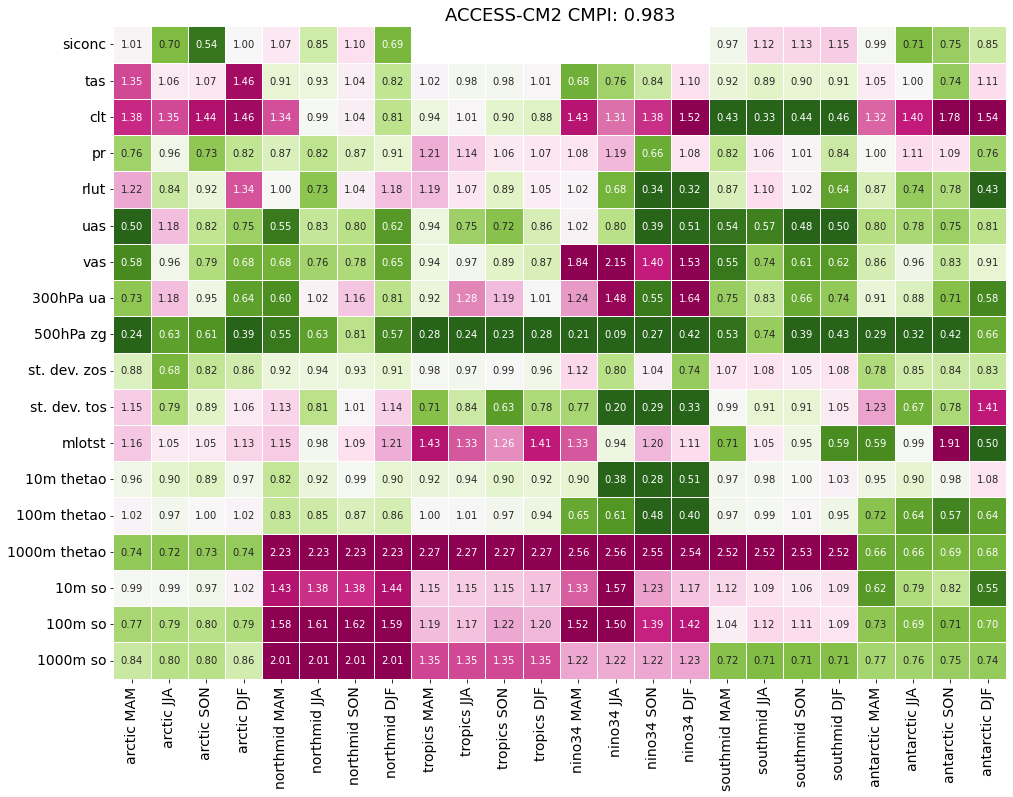

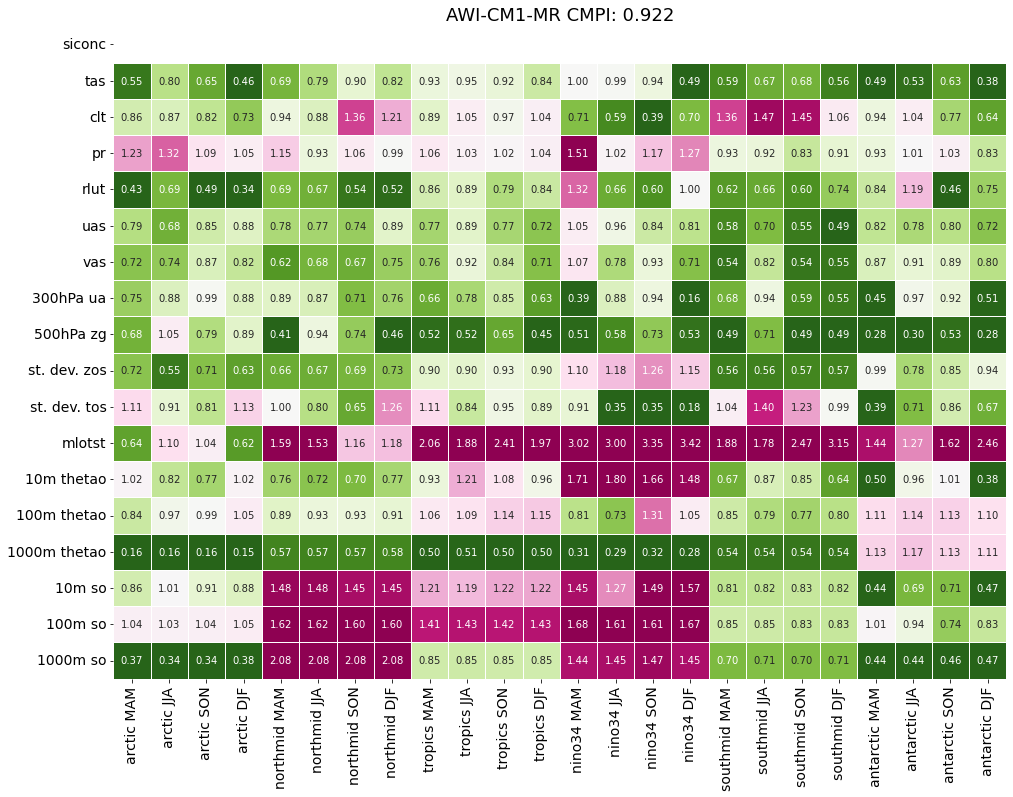

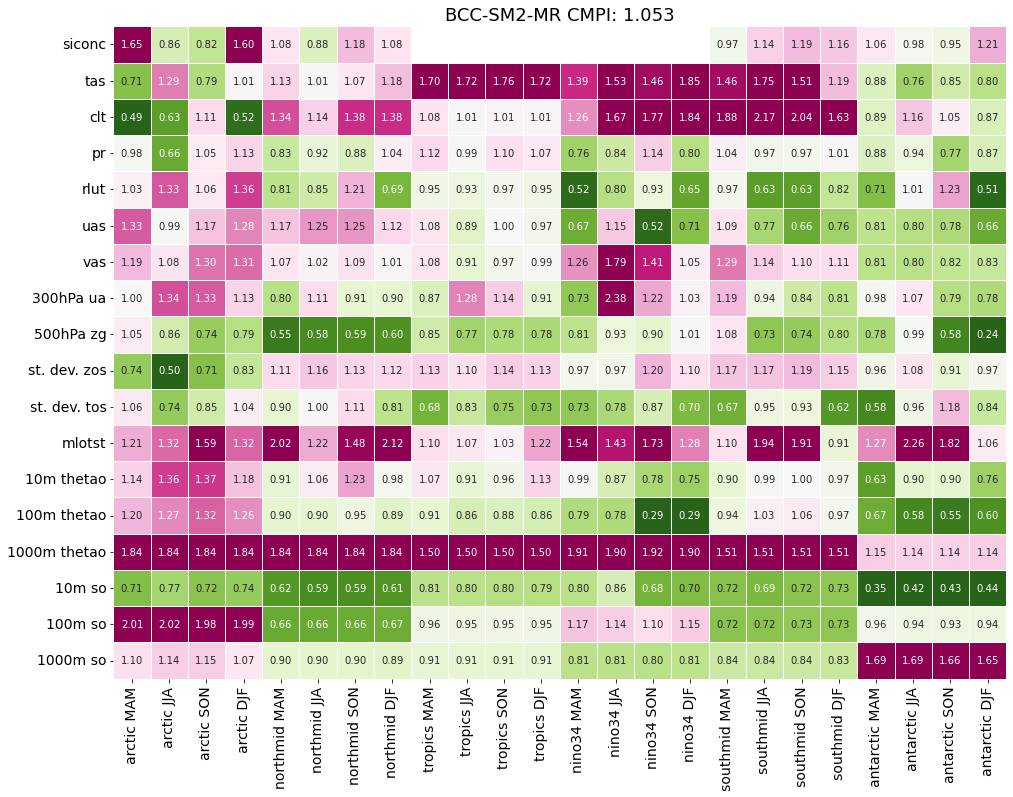

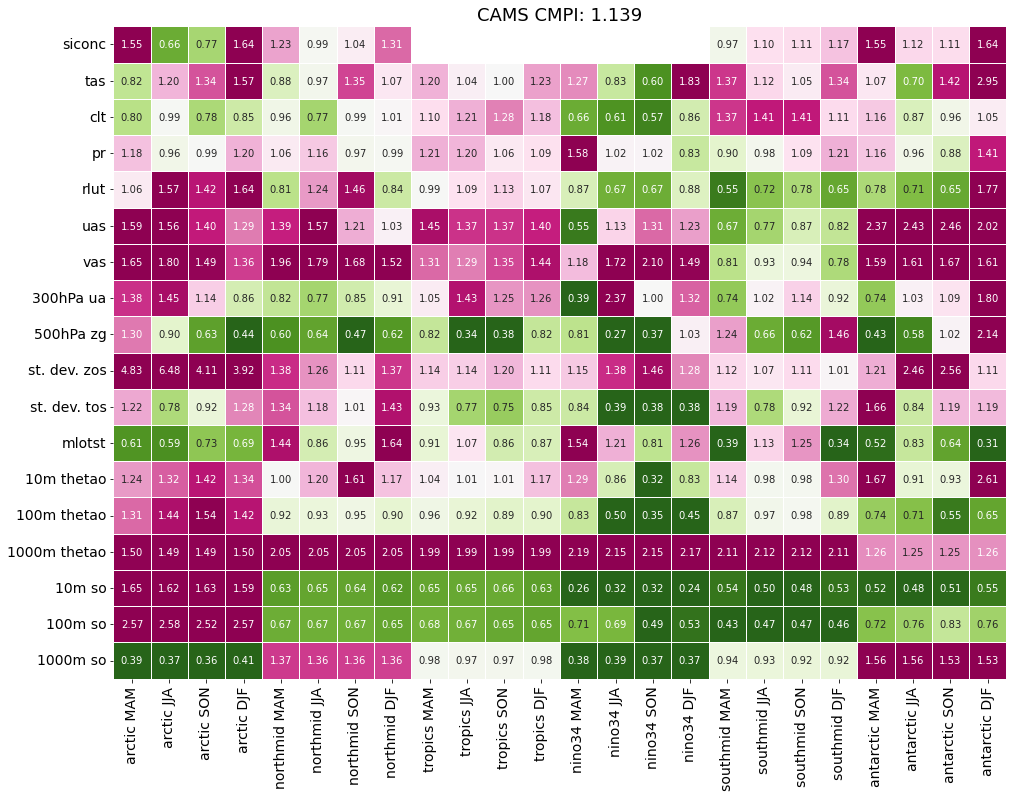

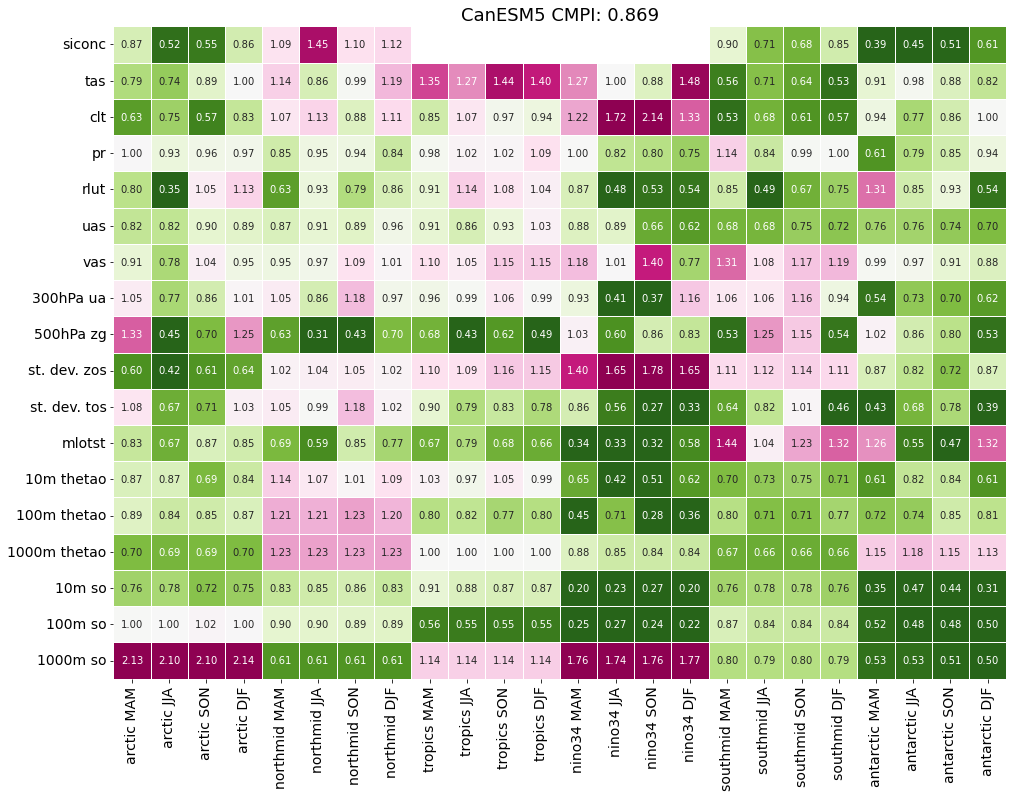

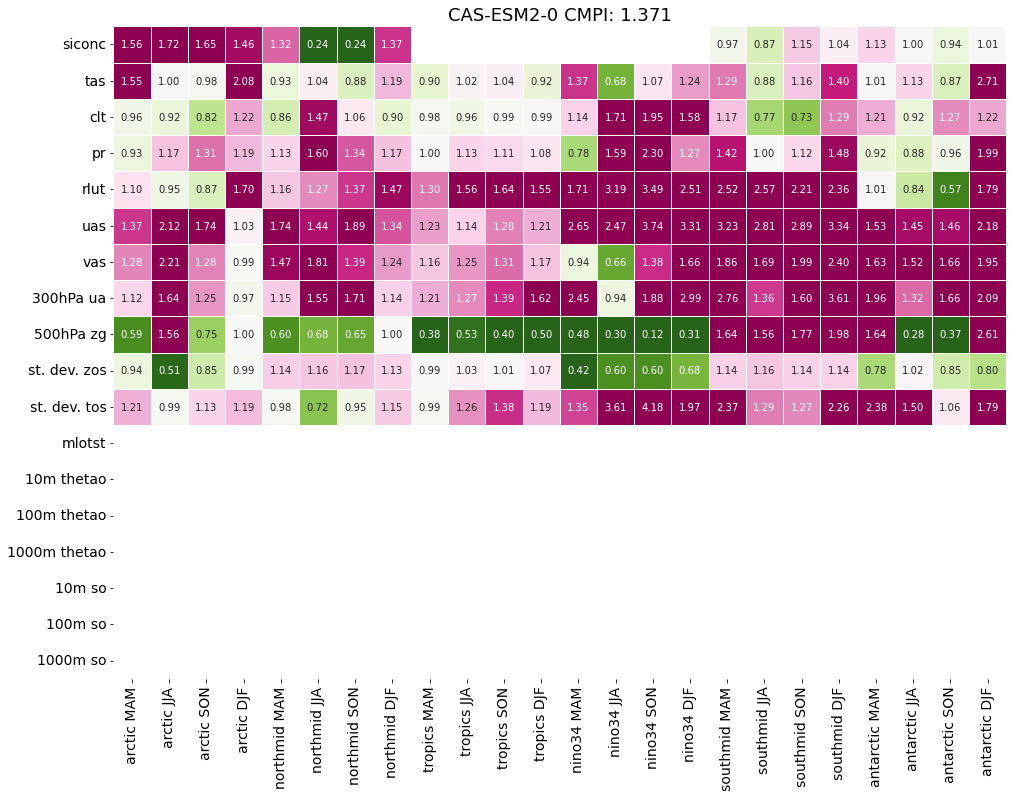

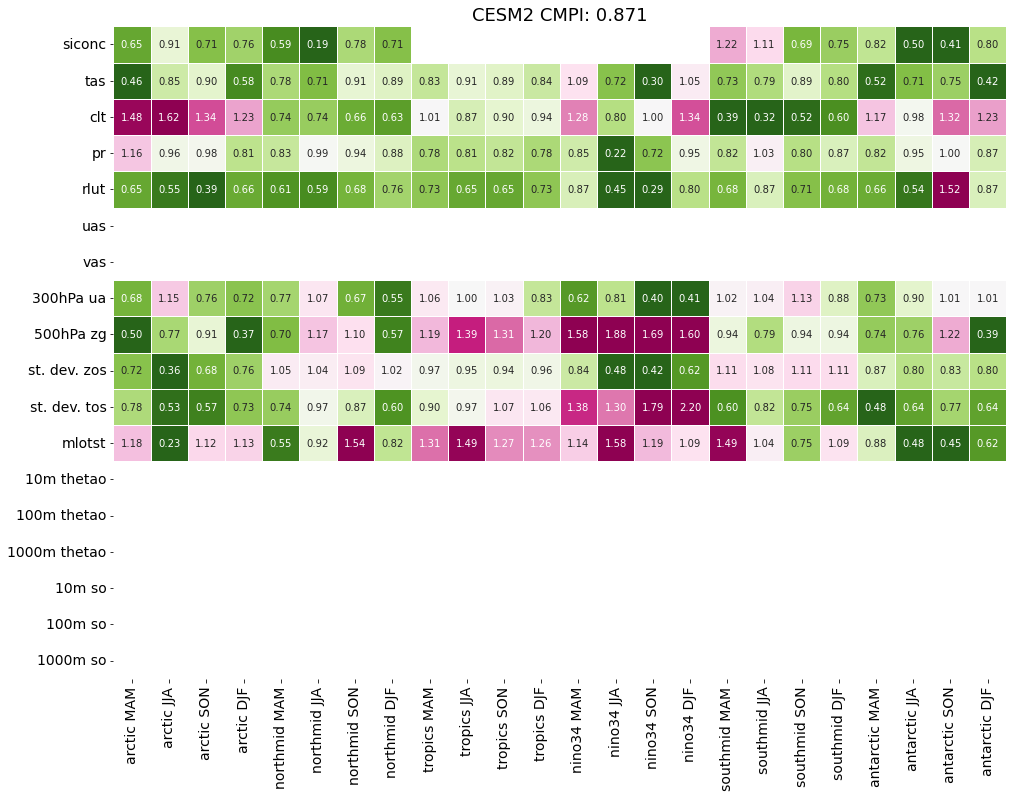

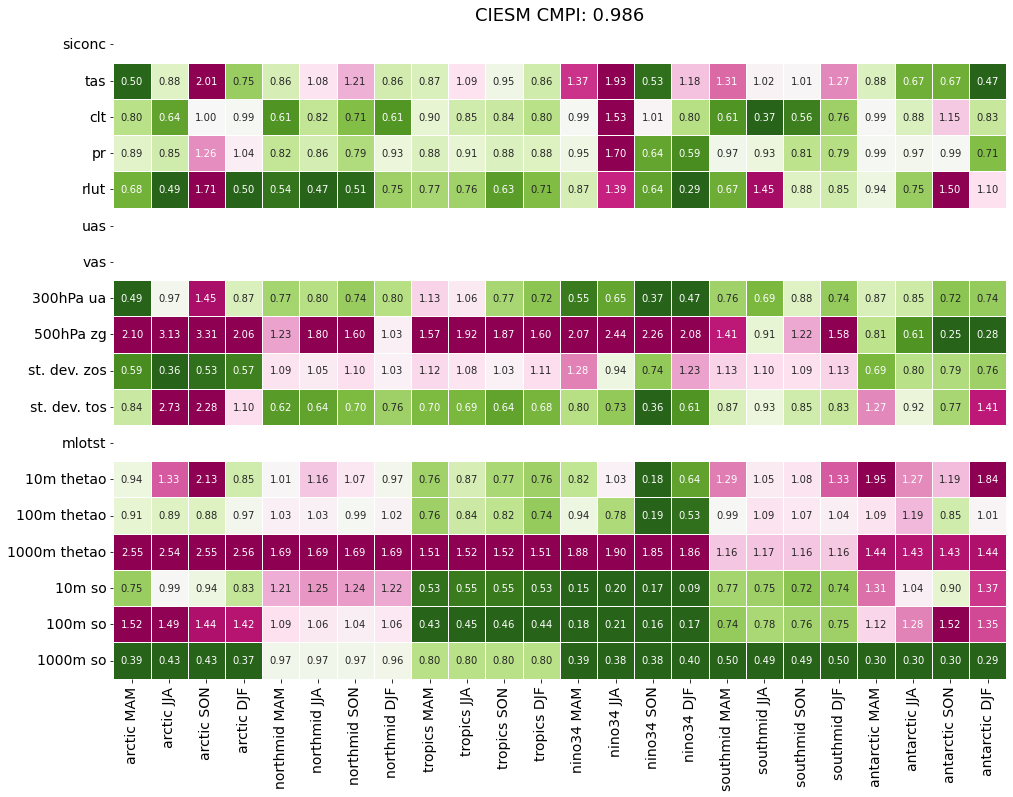

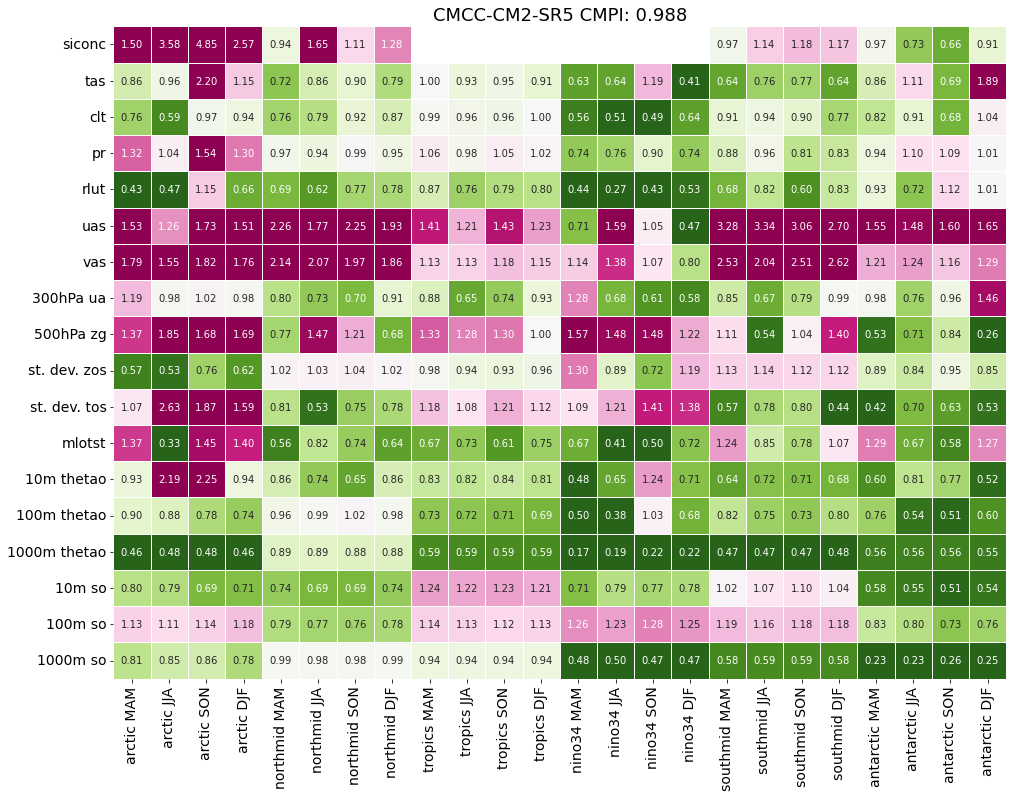

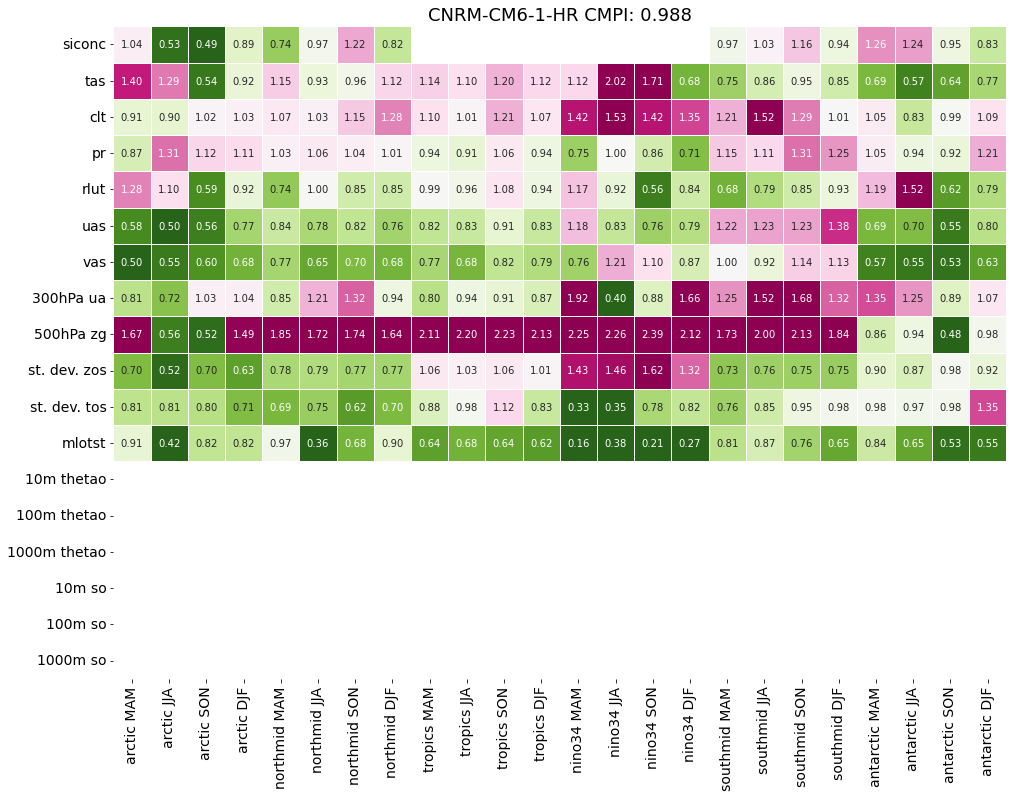

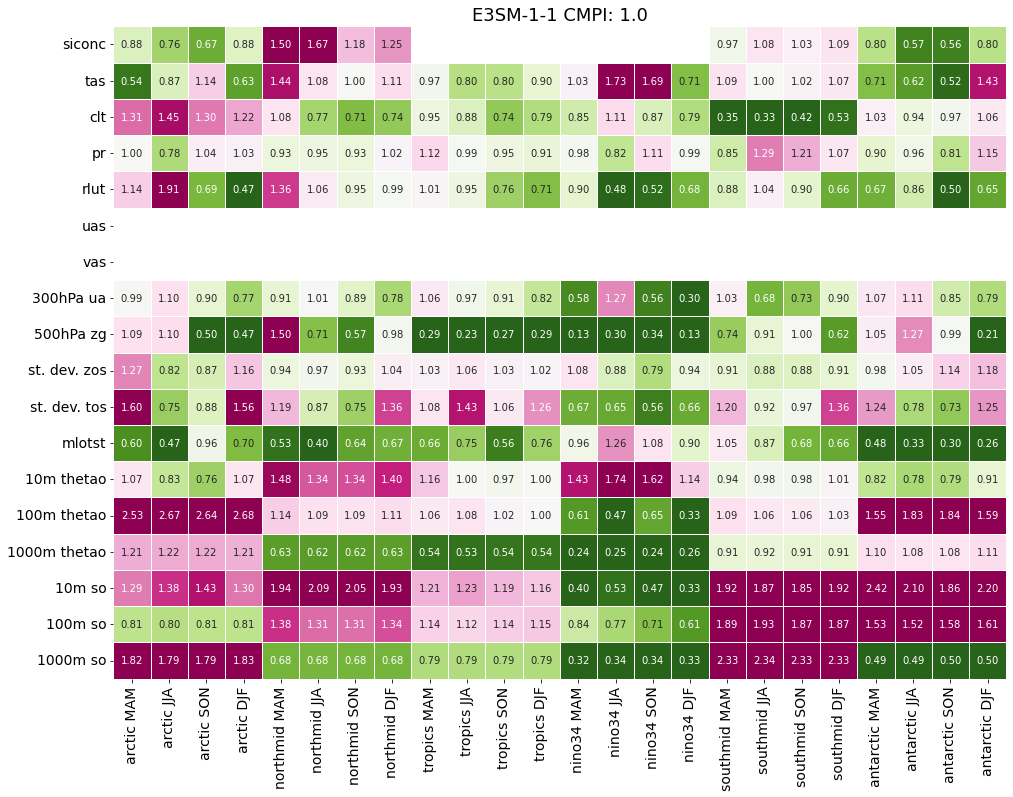

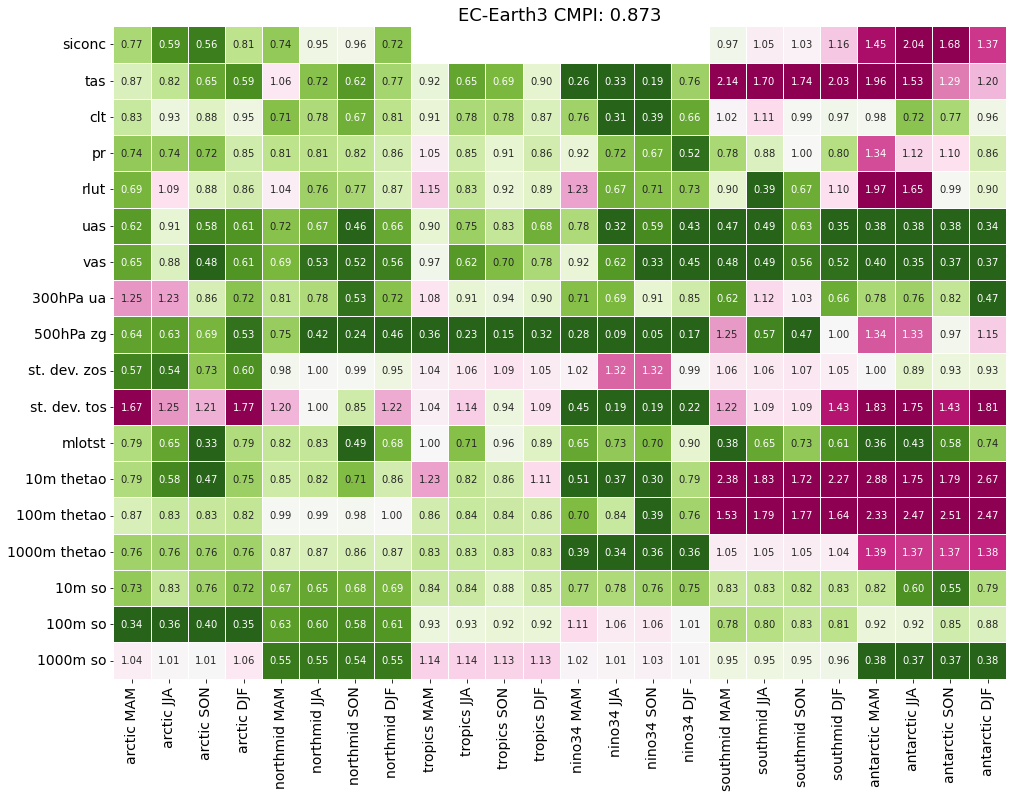

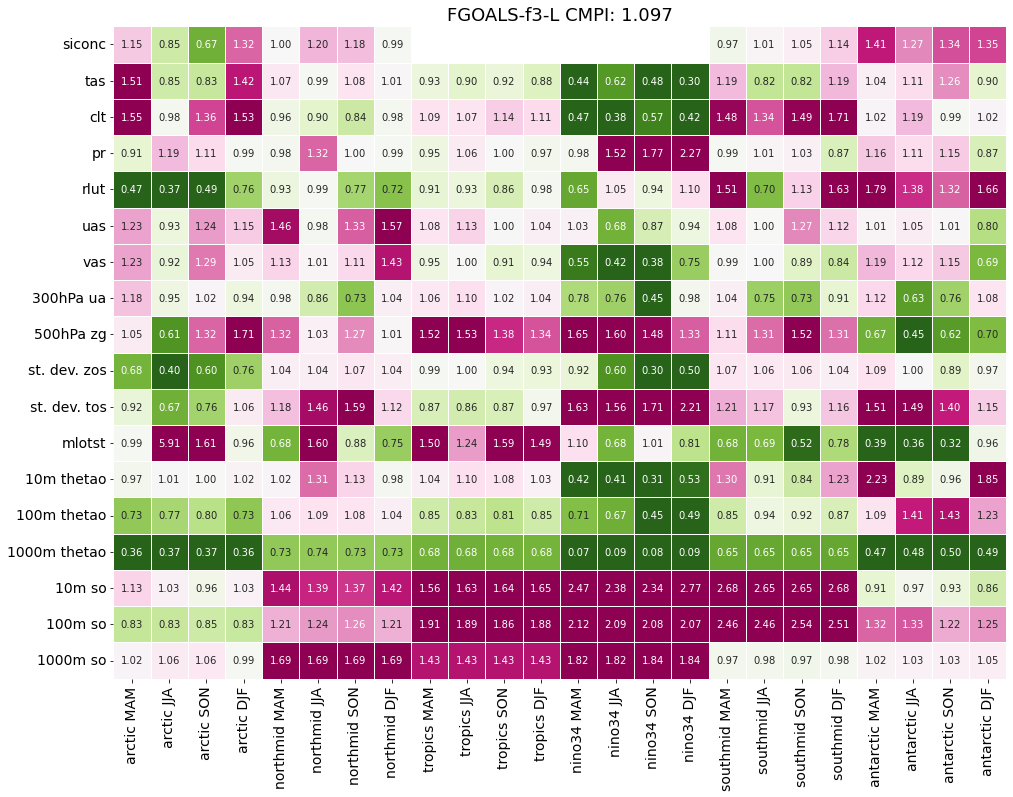

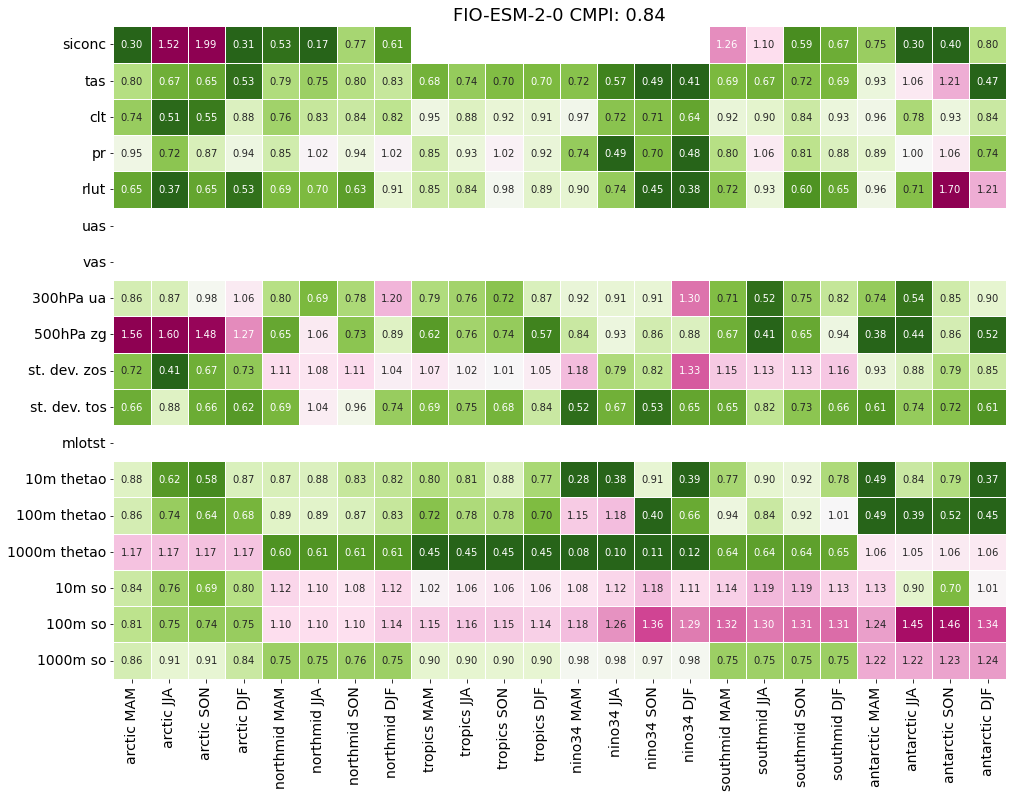

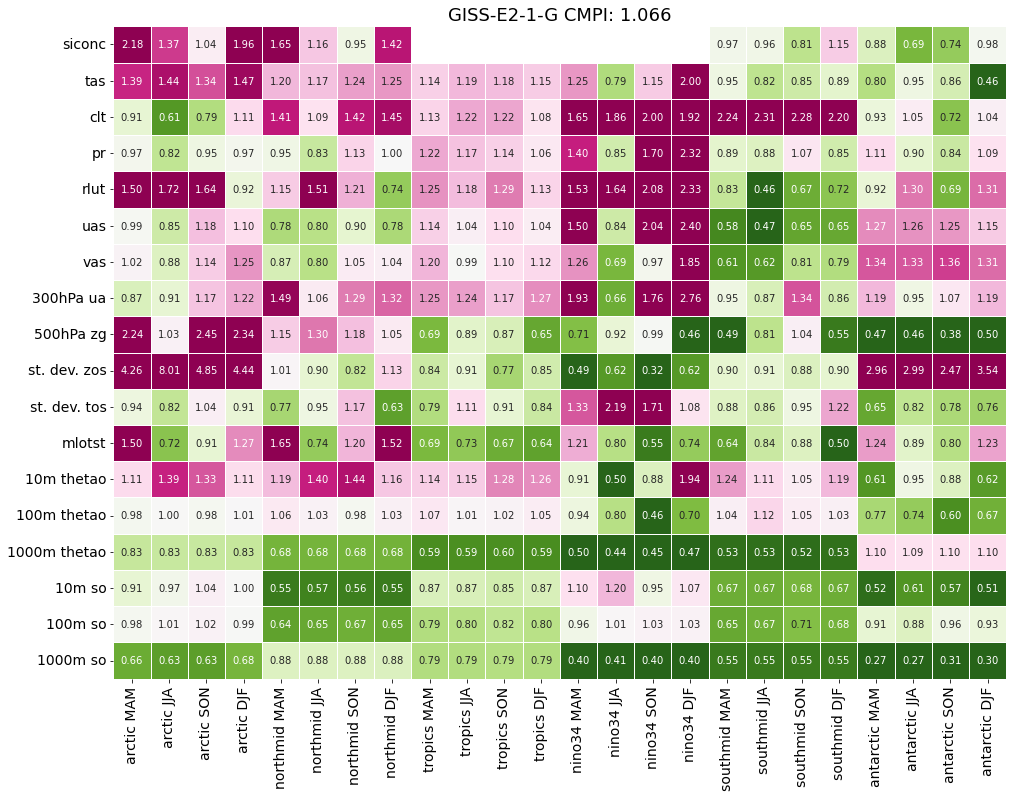

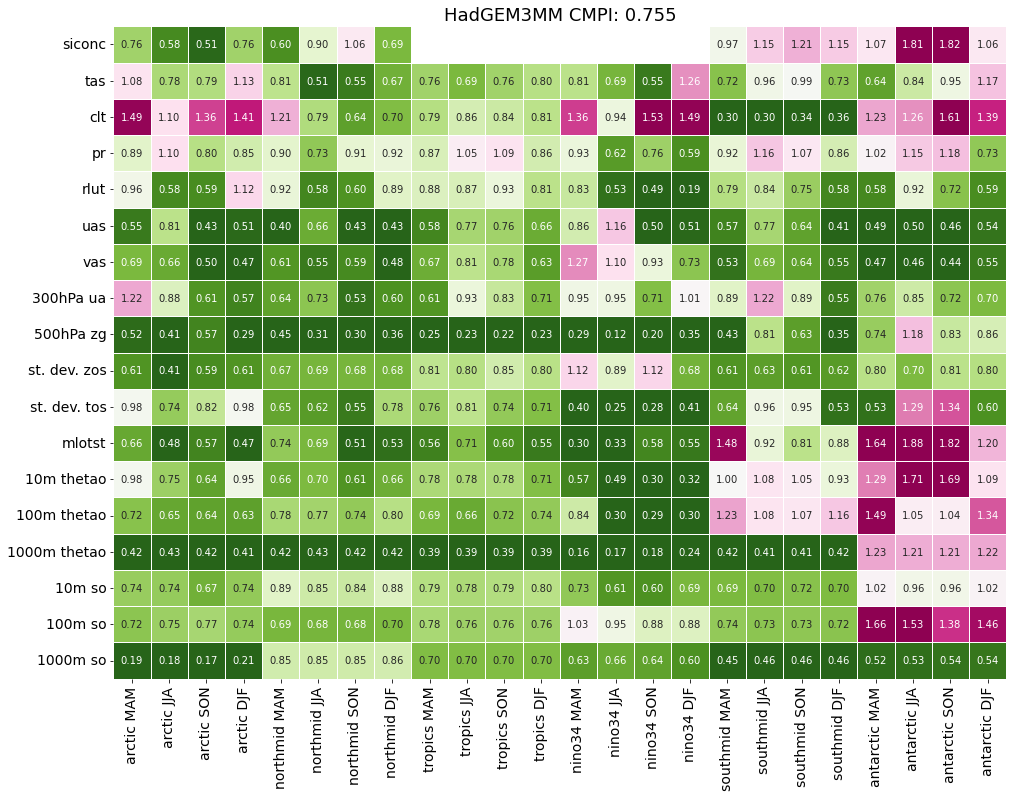

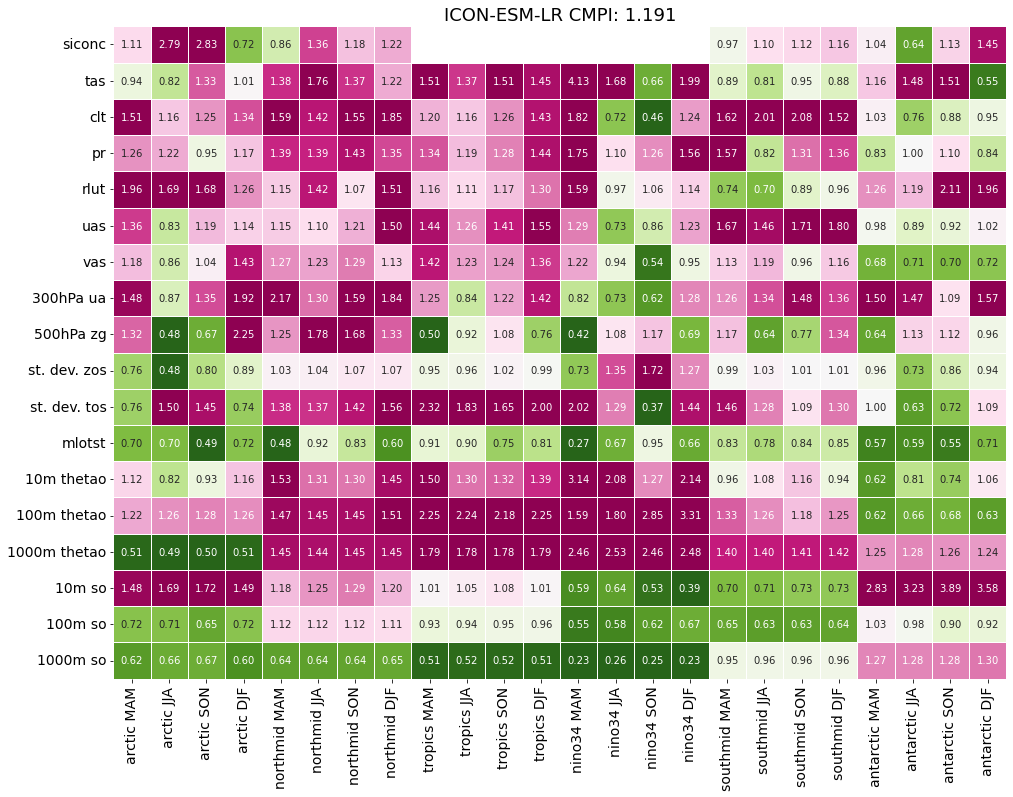

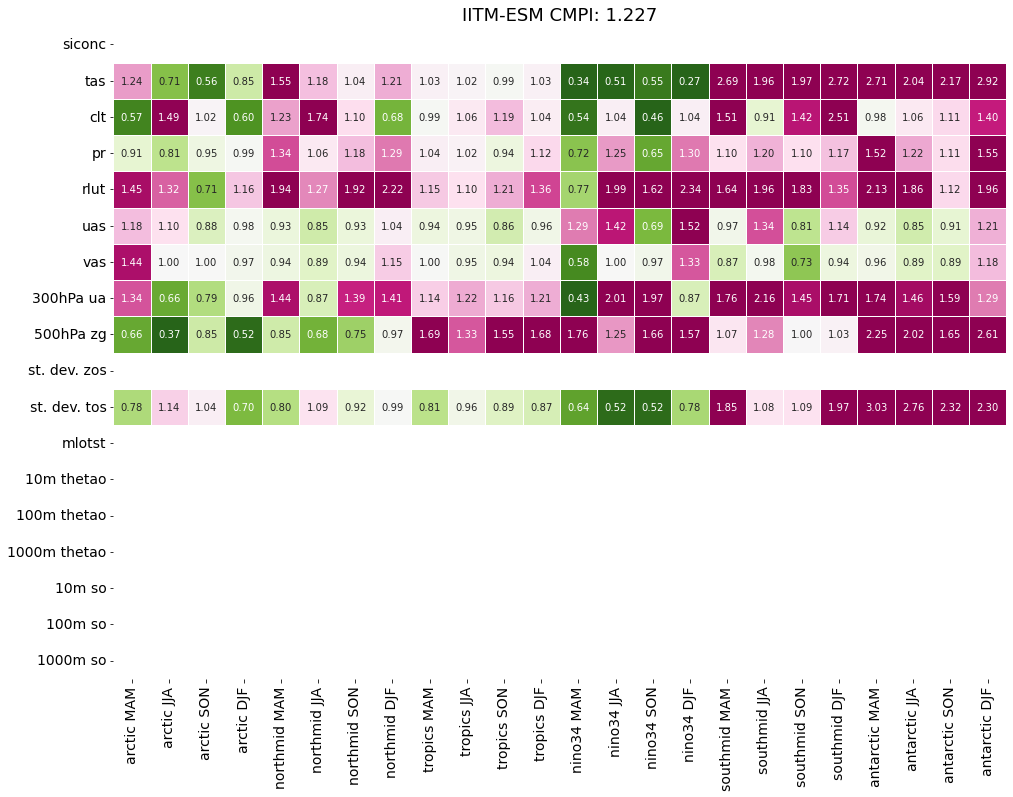

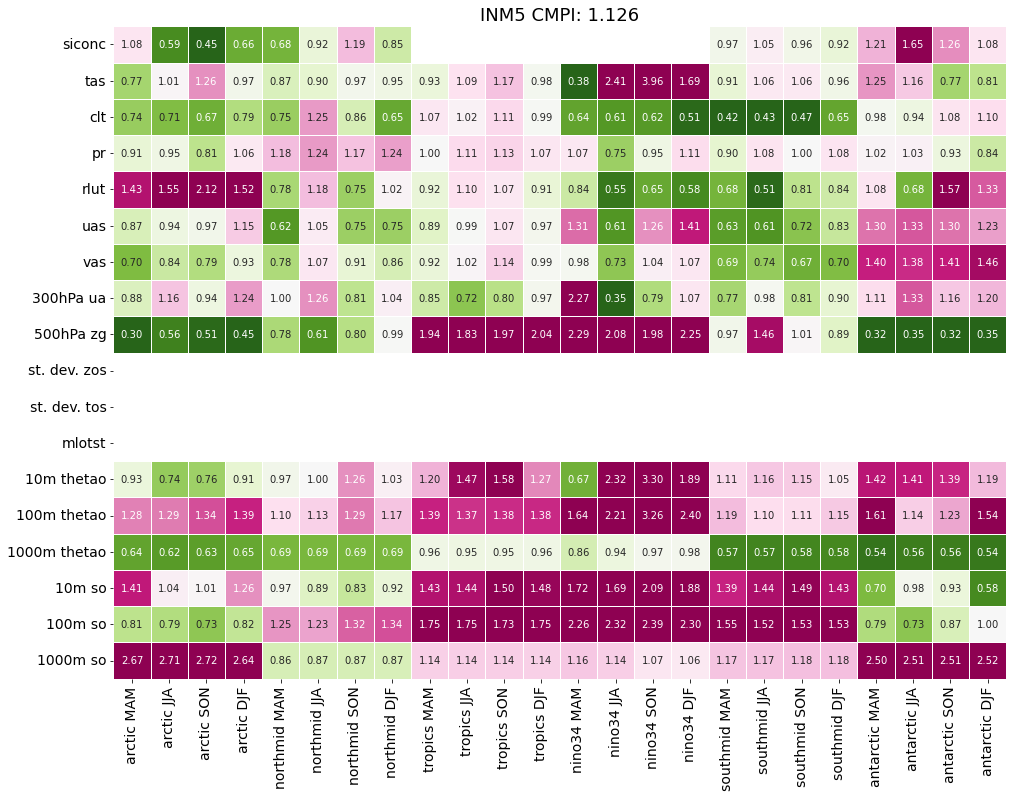

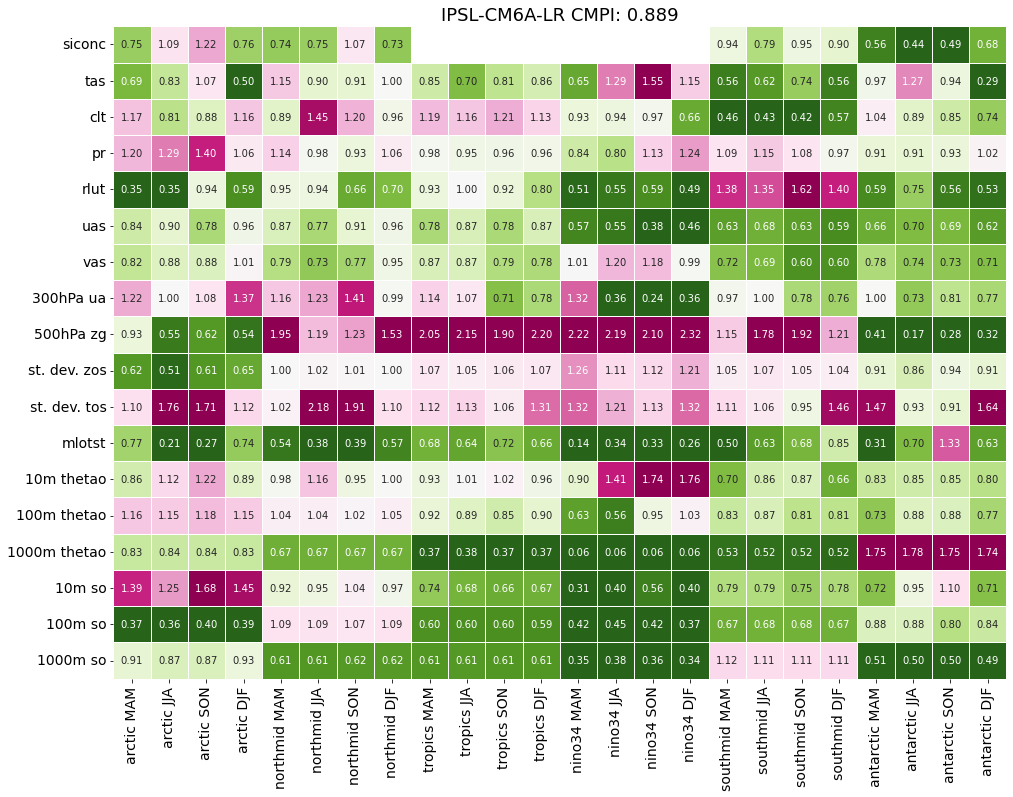

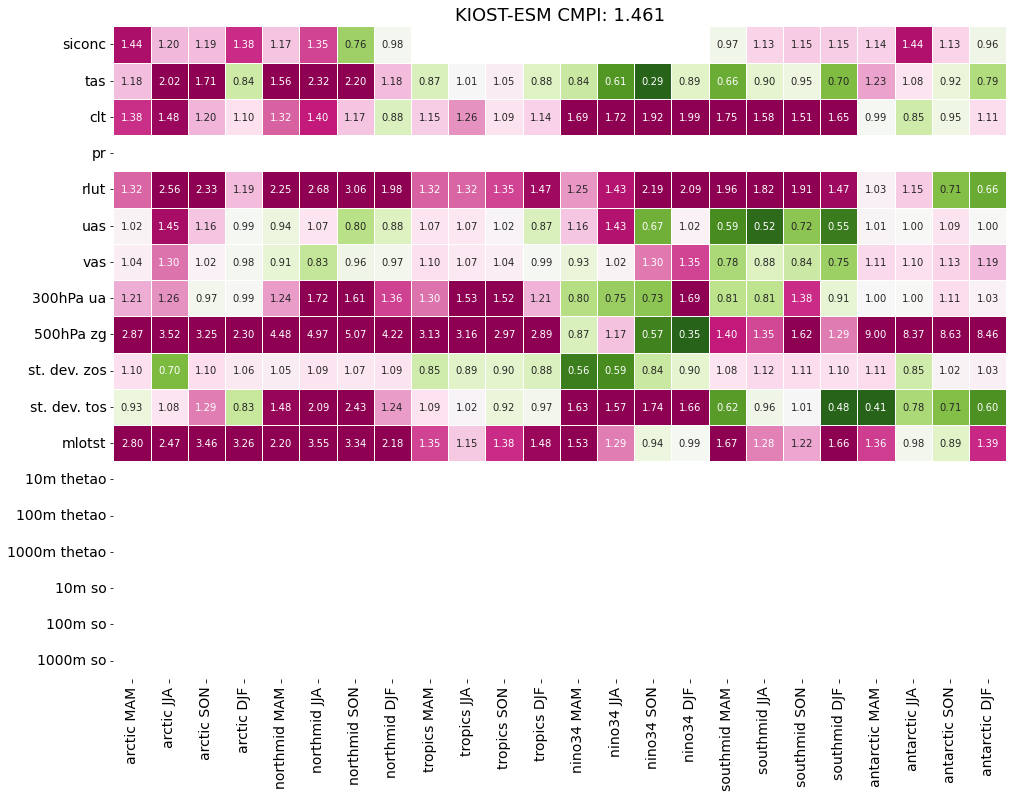

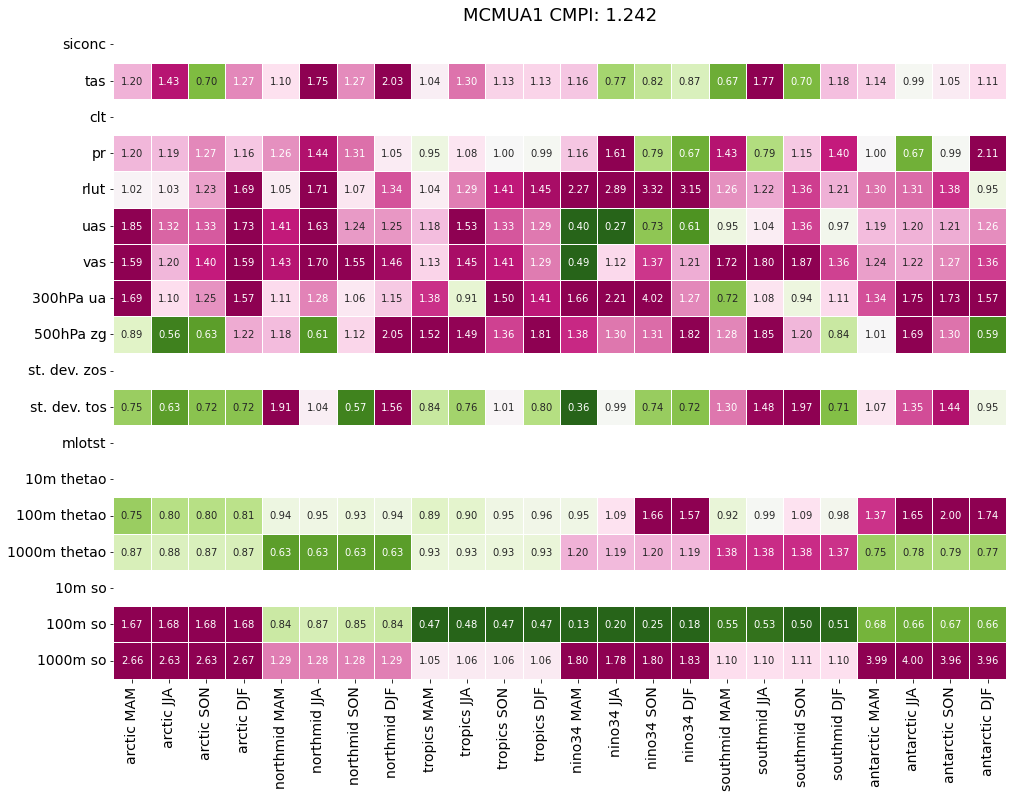

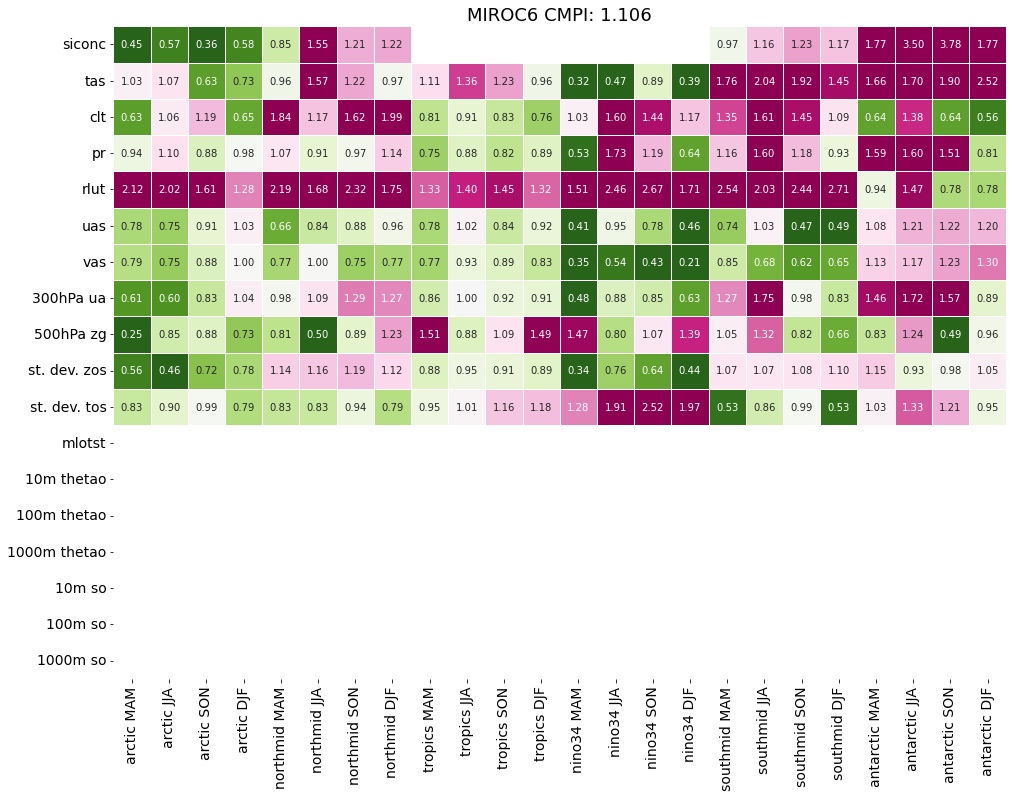

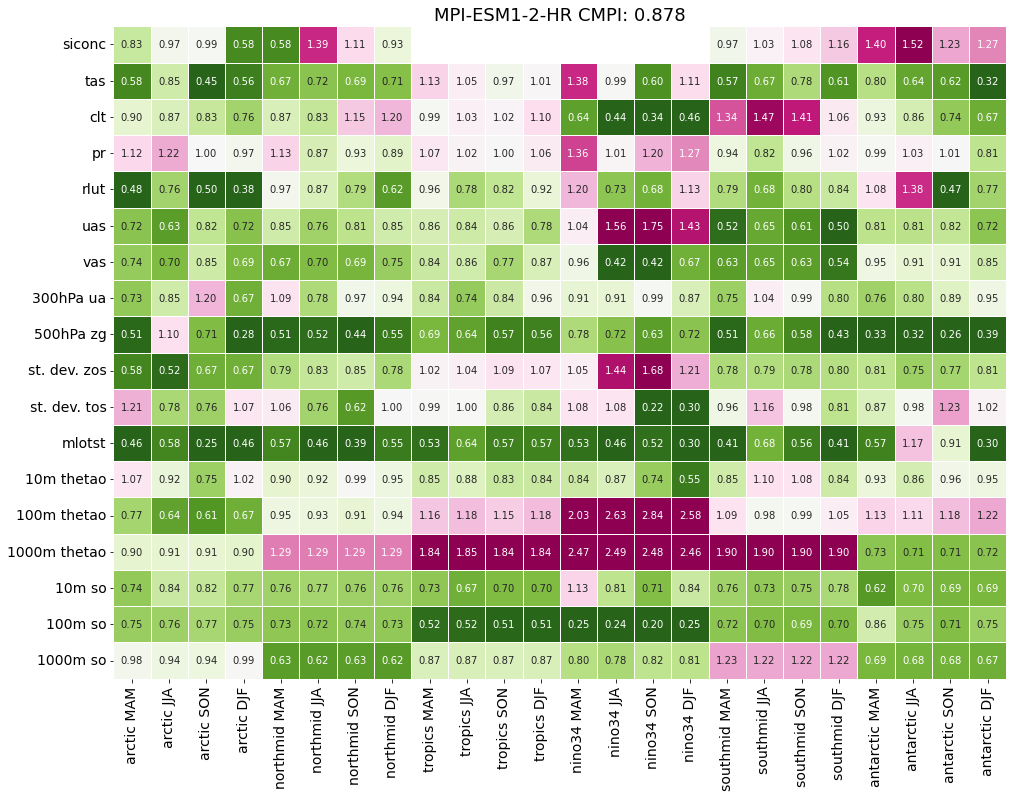

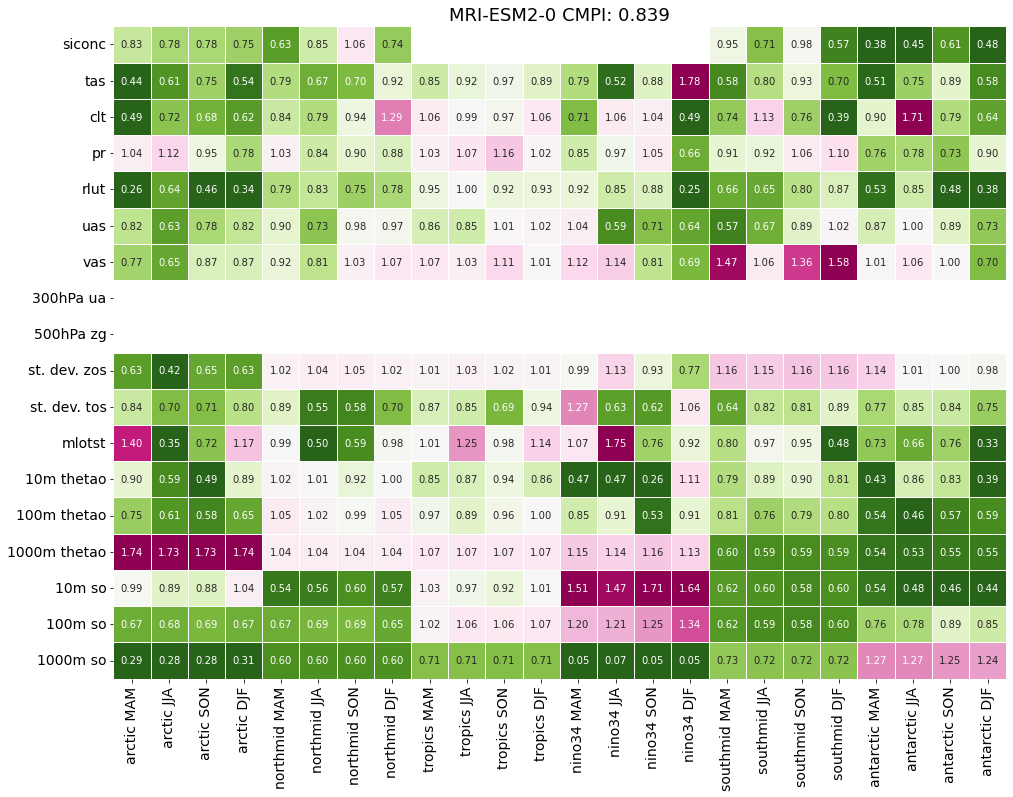

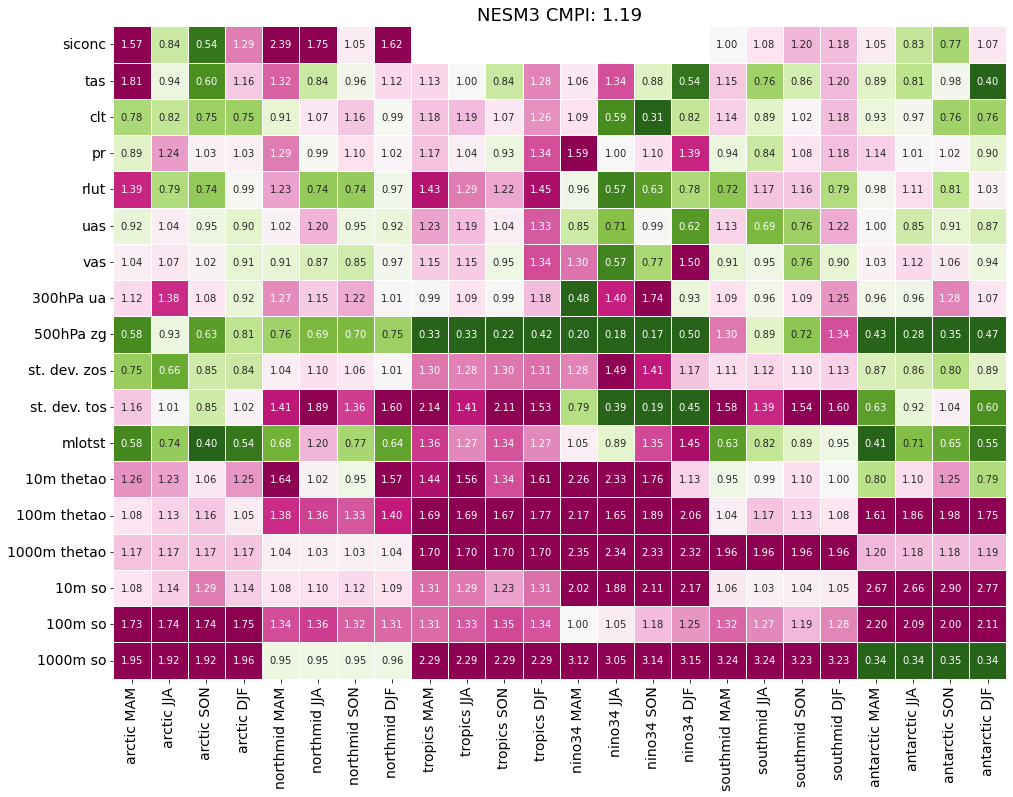

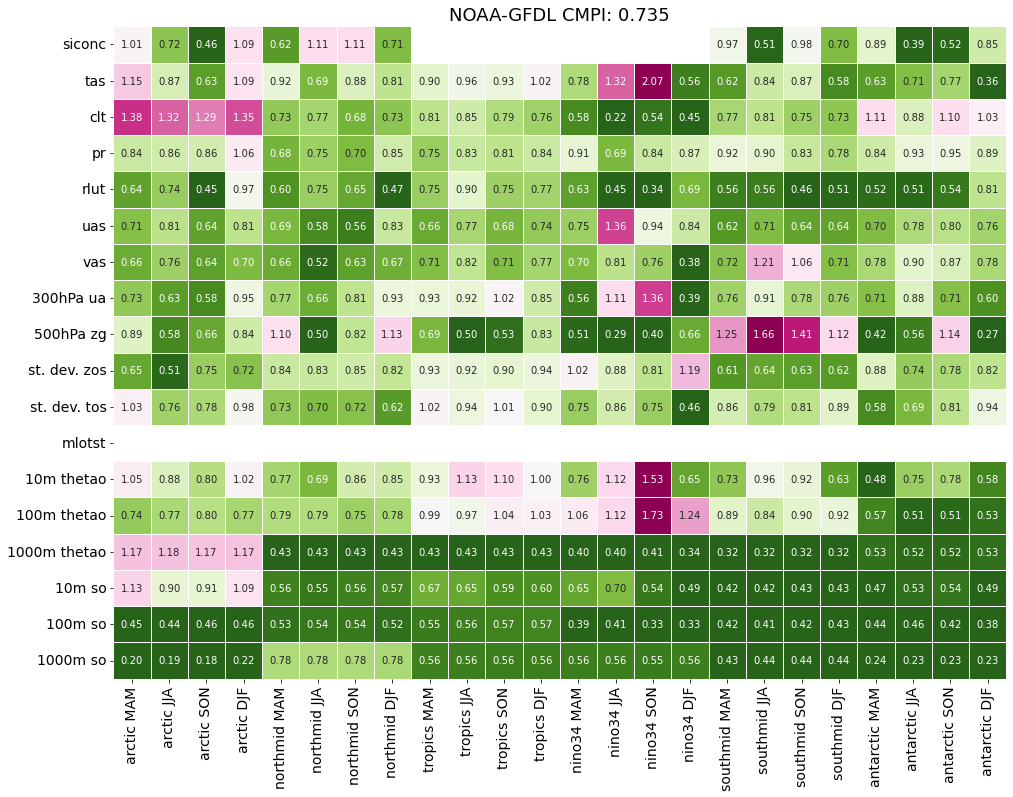

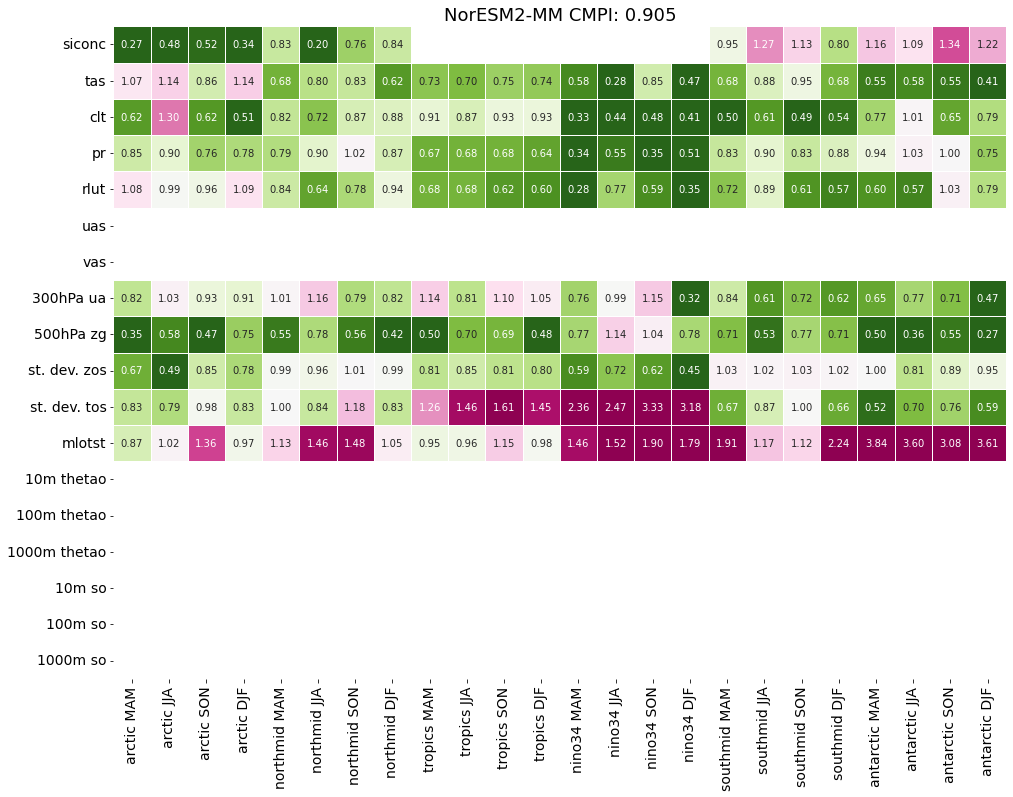

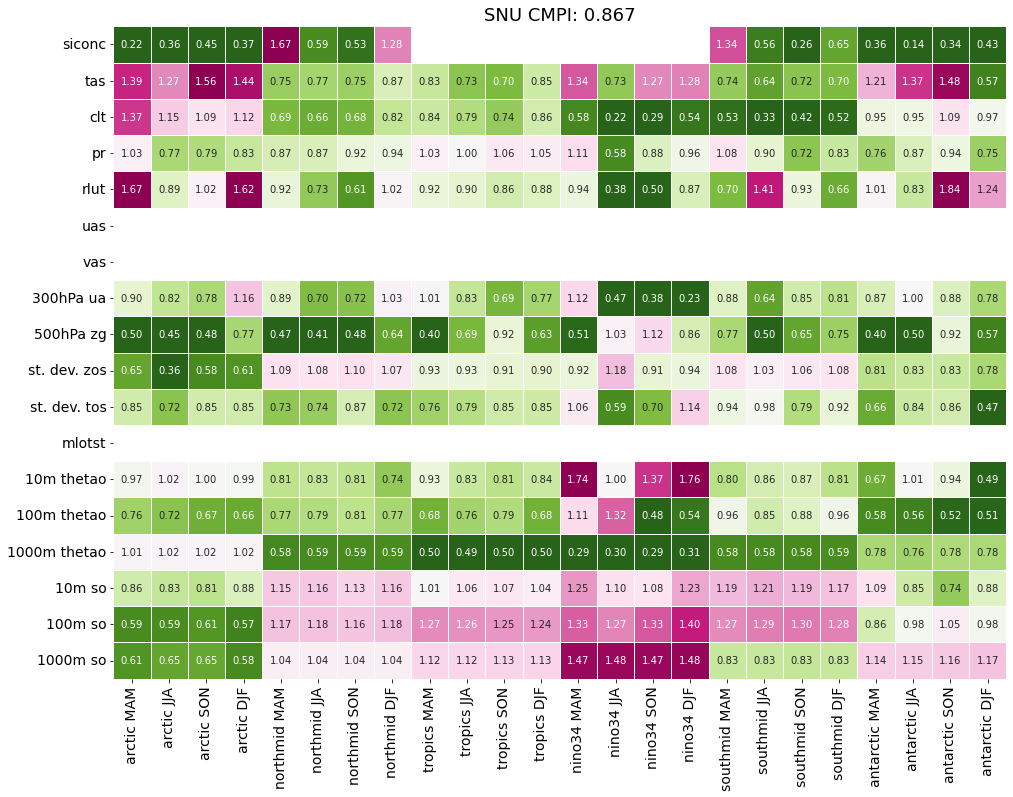

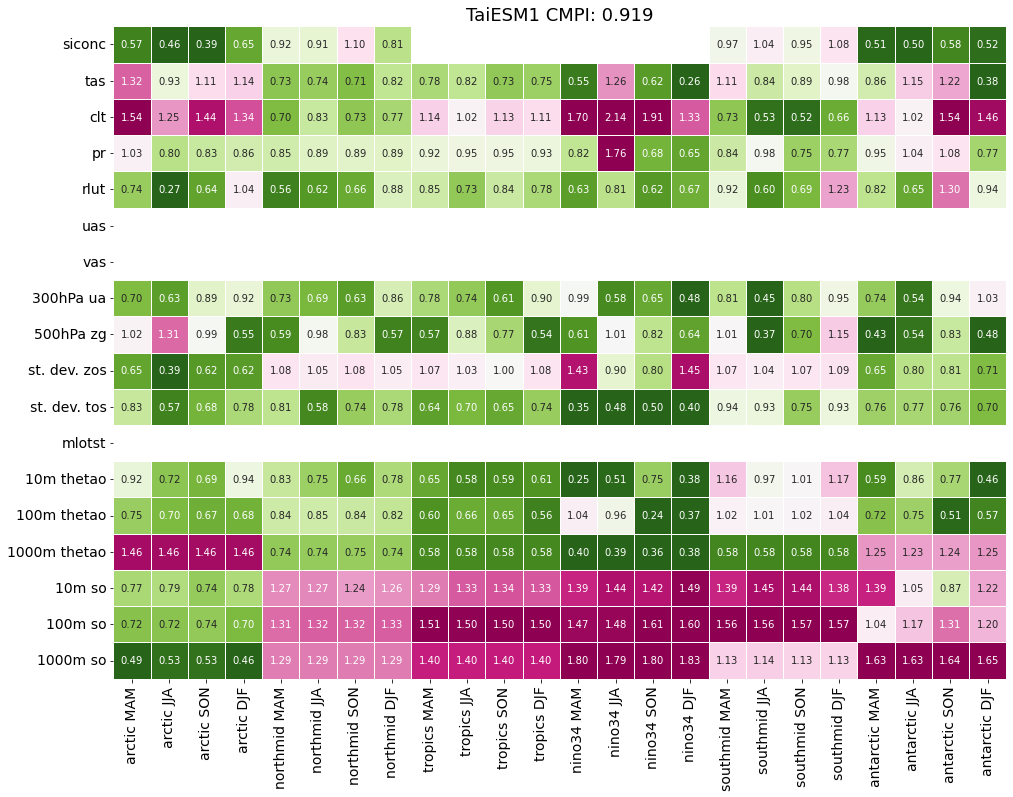

In [120]:
print('Reading precalculated evaluation field means of errors from csv files and plotting heatmap(s)')

max_depth=0
for var in var_depths:
    if len(var_depths[var]) > max_depth:
        max_depth = len(var_depths[var])

plt.rcParams.update({'figure.max_open_warning': 0})
collect_frac_non = OrderedDict()
for model in tqdm(models):
    df = pd.read_csv(out_path+'frac/'+model+'_fraction.csv', delimiter=' ')
    values = df['FracMeanError'] #you can also use df['column_name']
    r=0
    for var in obs:
        a=(df['Variable']==var).to_list()
        if verbose == 'true':
            if any(a): # Check if variable appears in list. If not, skip it.
                print('reading: ',model,var)
            else:
                print('filling: ',model,var)
        for depth in np.arange(0,len(var_depths[var])):
            for region in regions:
                for seas in seasons:
                    if any(a):
                        collect_frac_non[var+' '+region,var_depths[var][depth]+' '+seas]=values[r]
                        r+=1
                    else:
                        collect_frac_non[var+' '+region,var_depths[var][depth]+' '+seas]=np.nan


    seasons_plot = [' MAM', ' JJA', ' SON', ' DJF'] #adding spaces in front
    a=seasons_plot*len(regions)
    b=np.repeat(list(regions.keys()),len(seasons_plot))
    coord=[n+str(m) for m,n in zip(a,b)]
    
    index_obs=[]
    for var in obs:
        for depth in np.arange(0,len(var_depths[var])):
            if var_depths[var][depth] == 'surface':
                levelname=''
            else:
                levelname=var_depths[var][depth]+' '
            if var == 'zos' or var == 'tos':
                levelname='st. dev. '
            index_obs.append(levelname+var)
    if verbose == 'true':
        print(model,'number of values: ',len(list(collect_frac_non.values())),'; shape:',len(index_obs),'x',len(regions)*len(seasons))
    collect_frac_reshaped = np.array(list(collect_frac_non.values()) ).reshape(len(index_obs),len(regions)*len(seasons)) # transform to 2D
    collect_frac_dataframe = pd.DataFrame(data=collect_frac_reshaped, index=index_obs, columns=coord)

    fig, ax = plt.subplots(figsize=((len(regions)*len(seasons))/1.5,len(index_obs)/1.5))
    fig.patch.set_facecolor('white')
    plt.rcParams['axes.facecolor'] = 'white'
    ax = sns.heatmap(collect_frac_dataframe, vmin=0.5, vmax=1.5,center=1,annot=True,fmt='.2f',cmap="PiYG_r",cbar=False,linewidths=1)
    plt.xticks(rotation=90,fontsize=14)
    plt.yticks(rotation=0, ha='right',fontsize=14)
    plt.title(model+' CMPI: '+str(round(cmpi[model],3)), fontsize=18)
    
    plt.savefig(out_path+'plot/'+model+'.png',dpi=300,bbox_inches='tight')
    i+=1


  0%|                                                                                                                                                                                       | 0/30 [00:00<?, ?it/s]/p/project/chhb19/jstreffi/software/miniconda3/envs/pyfesom2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:15<00:00,  4.50s/it]


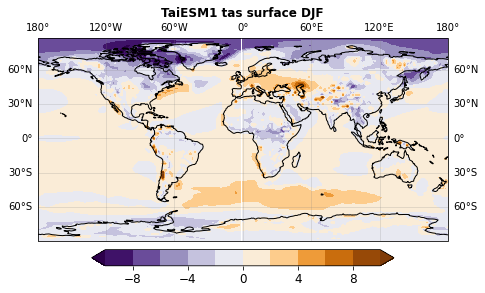

In [72]:
# Debug plot script


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import math

for model in tqdm(models):
    for seas in seasons:
        depth=0
        levels=np.linspace(-10,10,11)
        #levels=np.linspace(-0,2000,11)
        var='clt'

        %matplotlib inline

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4.5))
        ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE,zorder=3)


        data = ds_model[var,var_depths[var][depth],seas,model].to_array(var).values[0]
        obsp = np.squeeze(ds_obs[var,var_depths[var][depth],seas].to_array(var).values[0])
        #data_to_plot = data[0:90,:]-obsp[0:90,:]
        data_to_plot = obsp[0:90,:]

        lon = np.arange(0, 360, 2)
        lat = np.arange(-90, 90, 2)

        imf=plt.contourf(lon, lat, data_to_plot, cmap=plt.cm.PuOr_r,levels=levels, extend='both', transform=ccrs.PlateCarree())

        ax.set_title(model+' '+var+' '+var_depths[var][depth]+' '+seas,fontweight="bold")
        plt.tight_layout() 
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='-')

        gl.xlabels_bottom = False    
        cbar_ax_abs = fig.add_axes([0.15, 0.11, 0.7, 0.05])
        cbar_ax_abs.tick_params(labelsize=12)
        cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal')
        cb.ax.tick_params(labelsize='12')
        plt.savefig(out_path+'plot/maps/'+model+'_'+var+'_'+seas+'.png',dpi=200,bbox_inches='tight')


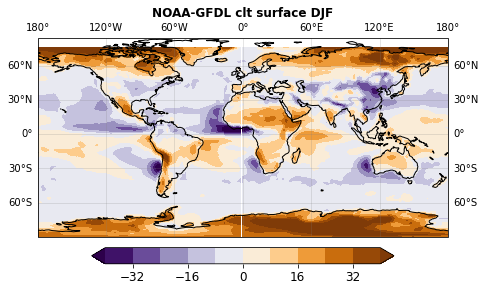

In [129]:
# Debug plot script


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import math

model="NOAA-GFDL"

for seas in seasons:
    depth=0
    levels=np.linspace(-40,40,11)
    #levels=np.linspace(-0,2000,11)
    var='clt'

    %matplotlib inline

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4.5))
    ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE,zorder=3)


    data = ds_model[var,var_depths[var][depth],seas,model].to_array(var).values[0]
    obsp = np.squeeze(ds_obs[var,var_depths[var][depth],seas].to_array(var).values[0])
    data_to_plot = data[0:90,:]-obsp[0:90,:]
    #data_to_plot = obsp[0:90,:]

    lon = np.arange(0, 360, 2)
    lat = np.arange(-90, 90, 2)

    imf=plt.contourf(lon, lat, data_to_plot, cmap=plt.cm.PuOr_r,levels=levels, extend='both', transform=ccrs.PlateCarree())

    ax.set_title(model+' '+var+' '+var_depths[var][depth]+' '+seas,fontweight="bold")
    plt.tight_layout() 
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='-')

    gl.xlabels_bottom = False    
    cbar_ax_abs = fig.add_axes([0.15, 0.11, 0.7, 0.05])
    cbar_ax_abs.tick_params(labelsize=12)
    cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal')
    cb.ax.tick_params(labelsize='12')
    plt.savefig(out_path+'plot/maps/'+model+'_'+var+'_'+seas+'.png',dpi=200,bbox_inches='tight')
